In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import re
import datetime
from tqdm import tqdm

import seaborn as sns
from matplotlib.patches import Patch
from matplotlib import pyplot as plt
# matplotlib.font_manager._rebuild()
# plt.rc('font', family='NanumGothic')

plt.rcParams.update({'figure.max_open_warning': 0})
plt.style.use('fivethirtyeight')
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

from sklearn.model_selection import train_test_split
from xgboost import plot_importance
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

from sklearn.model_selection import TimeSeriesSplit 
from matplotlib.patches import Patch 

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

import warnings
warnings.filterwarnings("ignore")

In [4]:
panel = pd.read_csv('/content/drive/MyDrive/학교/연구 자료/기후금융/finance_data/panel_df.csv')
panel = panel.iloc[:,1:].reset_index(drop=True)
train_data1_2 = pd.read_csv('/content/drive/MyDrive/학교/연구 자료/기후금융/finance_data/train_row_to_col.csv').iloc[:,1:]
train_data1_3 = pd.read_csv('/content/drive/MyDrive/학교/연구 자료/기후금융/finance_data/train_growth_rate.csv').iloc[:,1:]
train_data1_4 = pd.read_csv('/content/drive/MyDrive/학교/연구 자료/기후금융/finance_data/train_non_linear.csv').iloc[:,1:]

In [43]:
train_data1_2

cash/assets_0  liabilities/assets_0  liabilities-cash/assets_0  \
0                NaN                   NaN                        NaN   
1                NaN                   NaN                        NaN   
2           0.026243              0.805812                   0.779569   
3           0.011561              0.825602                   0.814041   
4           0.026253              0.819760                   0.793507   
...              ...                   ...                        ...   
54708            NaN                   NaN                        NaN   
54709            NaN                   NaN                        NaN   
54710       0.026243              0.805812                   0.779569   
54711       0.011561              0.825602                   0.814041   
54712       0.026253              0.819760                   0.793507   

       sales/cur_liabilities_0  cur_assets/cur_liabilities_0  \
0                          NaN                           NaN   
1                          NaN                           NaN   
2                     2.738511                      0.948362   
3                     1.887630                      0.740129   
4                     2.032037                      0.708325   
...                        ...                           ...   
54708                      NaN                           NaN   
54709                      NaN                           NaN   
54710                 2.738511                      0.948362   
54711                 1.887630                      0.740129   
54712                 2.032037                      0.708325   

       retained_earnings/cur_liabilities_0  non_cur_lia/non_cur_lia+worth_0  \
0                                      NaN                              NaN   
1                                      NaN                              NaN   
2                                 0.223232                         0.672144   
3                                 0.145565                         0.651638   
4                                 0.146367                         0.656881   
...                                    ...                              ...   
54708                                  NaN                              NaN   
54709                                  NaN                              NaN   
54710                             0.223232                         0.672144   
54711                             0.145565                         0.651638   
54712                             0.146367                         0.656881   

       interest/cash_flow_0  interest/ebitda_0  inven/sales_0  \
0                       NaN                NaN            NaN   
1                       NaN                NaN            NaN   
2                  0.000012           0.000008       0.160206   
3                  0.000000           0.000000       0.174542   
4                  0.001486           0.000561       0.142004   
...                     ...                ...            ...   
54708                   NaN                NaN            NaN   
54709                   NaN                NaN            NaN   
54710              0.000012           0.000008       0.160206   
54711              0.000000           0.000000       0.174542   
54712              0.001486           0.000561       0.142004   

       sales/net_income_0  gross_margin/sales_0  sales/retained_earnings_0  \
0                     NaN                   NaN                        NaN   
1                     NaN                   NaN                        NaN   
2               61.788109              0.232182                  12.267552   
3               76.166253              0.272677                  12.967588   
4               84.247871              0.272204                  13.883191   
...                   ...                   ...                        ...   
54708                 NaN                   NaN                        NaN   
54709  

# #1. 전처리 & 파생변수

In [23]:
panel = pd.read_csv('/content/drive/MyDrive/학교/연구 자료/기후금융/finance_data/panel_df.csv')
panel = panel.iloc[:,1:].reset_index(drop=True)

# return 변수 float
panel['return'] = panel['return'].astype(str)
panel['return'] = [re.sub(",", "", row) for row in panel['return']]
panel['return'] = panel['return'].astype(float)

# astype 또는 to_datetime로 변환
# panel['year'] = panel['year'].astype(str)
panel['최초상장일자'] = panel['최초상장일자'].astype(str)
panel['상장일자'] = panel['상장일자'].astype(str)
panel['최초상장일자'] = [re.sub(".0$", "", row) for row in panel['최초상장일자']]
panel['상장일자'] = [re.sub(".0$", "", row) for row in panel['상장일자']]
panel['최초상장일자'] = pd.to_datetime(panel['최초상장일자'])
panel['상장일자'] = pd.to_datetime(panel['상장일자'])

panel['unlist_year'] = panel['unlist_date'].str.slice(stop=4)
# panel['unlist_date'] = pd.to_datetime(panel['unlist_date'])
# panel['Accounting_Closing'] = panel['Accounting_Closing'].astype(int) #오류남
panel['unlist_reason'] = panel['unlist_reason'].astype(str)

# 금융회사 제외
panel = panel[panel['대분류']!='금융 및 보험업']
panel = panel.drop(['대분류', '세분류', '세세분류','소분류', '중분류', '코드세분류', '코드세세분류', '코드소분류', '코드중분류', '주거래은행'], axis=1)

## (2) 상장폐지 사유 전처리 & 카테고리화

In [24]:
panel['unlist_reason_ctg'] = panel['unlist_reason']

## 상장폐지신청 dict로 class화 
ctg_dict = {}
ctg_list = ['(상장폐지 ?신청)|(^신청)','(신청)|(요청)|(자진)',"(상장$)|(^시장)|(^증권)",'(편입)|(흡수)',"지주회사", "영업의 양도", "기타", "계약이전",
            '해산', "부도", '전액', '자본', "(^감사(으로)? ?의견( 의견)? ?거절)|(범위 ?제한)|(감사의견 ?부적정)|(감사의견거절)", "경영", 
            "(시가 ?총액)|(시총)","주식","보통주", "정리", "영업", "유예", "정지", "제출", "부진", "액면가", "불성실", "화의 불인가", "회생"]

for ctg in ctg_list:
  r = re.compile(ctg) 
  v = list(set([row for row in panel['unlist_reason_ctg'] if r.search(row) is not None]))
  k = min(v, key=len)
  ctg_dict[k] = v
  panel['unlist_reason_ctg'] = panel['unlist_reason_ctg'].replace(v, '0')

# keys 이름 수정
# ctg_dict["자본잠식률 50% 이상"] = ctg_dict["2회연속 자본잠식률 50%이상"]
# ctg_dict["불성실공시법인지정"] = ctg_dict["최근 2년간 3회이상 불성실공시법인으로 지정"]

# del ctg_dict["2회연속 자본잠식률 50%이상"], ctg_dict["최근 2년간 3회이상 불성실공시법인으로 지정"]

In [25]:
ctg_dict.keys()

dict_keys(['신청에 의한 상장폐지', '자진등록취소', '증권거래소 상장', '피흡수합병', '지주회사(최대주주등)의 완전자회사화 등', '주된영업의 양도', '기타 등록취소', '계약이전', '해산 사유 발생', '부도', '자본전액잠식', '2연속 자본잠식률 50% 이상', '감사의견거절', '기업의 계속성 및 경영의 투명성 등을 종합적으로 고려하여 상장폐지기준에 해당', '시가총액 미달', '주식양도 제한', '보통주 주가수준미달', '회사정리절차 폐지 결정', '영업활동정지 6월 계속', '상장폐지유예기간종료', '당좌거래정지', '사업보고서 법정제출기한 익일부터 10일이내 미제출', '2분기 연속 거래실적부진사유 미해소', '액면가액일정비율 미달', '최근 2년간 3회이상 불성실공시법인으로 지정', '화의 불인가', '회생절차폐지결정사유 및 당해 코스닥시장상장법인의 계속기업 가능성 유무를 고려한 결과 상장폐지기준에 해당한다고 결정'])

In [26]:
## dict로 replace
panel['unlist_reason_ctg'] = panel['unlist_reason']

# values에 해당되면 key로 치환
key_list = []

for reason in panel['unlist_reason_ctg']:
  key = [k for k, v in ctg_dict.items() if reason in v]
  if len(key)==0:
    key_list.extend(reason)
  else:
    key_list.extend(key)

panel['unlist_reason_ctg'] = key_list
panel[panel['unlist_reason_ctg']!=panel['unlist_reason']][['unlist_reason_ctg', 'unlist_reason']]

unlist_reason_ctg       unlist_reason
76864             자본전액잠식        자본전액잠식 2년 계속
76865             자본전액잠식        자본전액잠식 2년 계속
76866             자본전액잠식        자본전액잠식 2년 계속
76867             자본전액잠식        자본전액잠식 2년 계속
76868             자본전액잠식        자본전액잠식 2년 계속
...                  ...                 ...
111899       신청에 의한 상장폐지  상장폐지 신청('22.04.14)
111900       신청에 의한 상장폐지  상장폐지 신청('22.04.14)
111901       신청에 의한 상장폐지  상장폐지 신청('22.04.14)
111902       신청에 의한 상장폐지  상장폐지 신청('22.04.14)
111903       신청에 의한 상장폐지  상장폐지 신청('22.04.14)

[19168 rows x 2 columns]

## (3) 재무부실 사유 상장폐지기업 class 파생변수

In [27]:
## 재무적 이유로 상장폐지 하지 않은 사유 필터
panel['fnc_rsn_unlst_year'] = panel['unlist_reason_ctg']

panel['fnc_rsn_unlst_year'] = panel['fnc_rsn_unlst_year'].replace(['해산 사유 발생', '영업활동정지 6월 계속', '자본전액잠식', '회사정리절차 폐지 결정', 
                                                         '감사의견거절', '주식양도 제한', '상장폐지유예기간종료', '부도', 
                                                         '보고서 또는 서류 미제출', '자본잠식률 50% 이상', '시가총액 미달', '보통주 주가수준미달', 
                                                         '당좌거래정지', '액면가액일정비율 미달', '기업의 계속성 및 경영의 투명성 등을 종합적으로 고려하여 상장폐지기준에 해당',
                                                         '화의 불인가', '불성실공시법인지정', '2분기 연속 거래실적부진사유 미해소', '사업보고서 법정제출기한 익일부터 10일이내 미제출',
                                                         '회생절차폐지결정사유 및 당해 코스닥시장상장법인의 계속기업 가능성 유무를 고려한 결과 상장폐지기준에 해당한다고 결정','공시서류 미제출(반기보고서) 후 차기보고서 미제출',
                                                         '공시서류 미제출(사업보고서) 후 10일이내 미제출', '2연속 자본잠식률 50% 이상','최근 2년간 3회이상 불성실공시법인으로 지정', '2회연속 자본잠식률 50%이상'],'1')

panel['fnc_rsn_unlst_year'] = panel['fnc_rsn_unlst_year'].replace(['피흡수합병','자진등록취소','신청에 의한 상장폐지', '지주회사(최대주주등)의 완전자회사화 등',
                                                          '코스닥시장 상장', '기타 등록취소', '주된영업의 양도','계약이전','증권거래소 상장'],'0')

panel[['unlist_reason_ctg', 'fnc_rsn_unlst_year']] # {상장폐지X, 그외사유 상장폐지: 0}, {재무사유 상장폐지: 1}

unlist_reason_ctg fnc_rsn_unlst_year
0                      0                  0
1                      0                  0
2                      0                  0
3                      0                  0
4                      0                  0
...                  ...                ...
111899       신청에 의한 상장폐지                  0
111900       신청에 의한 상장폐지                  0
111901       신청에 의한 상장폐지                  0
111902       신청에 의한 상장폐지                  0
111903       신청에 의한 상장폐지                  0

[101280 rows x 2 columns]

In [28]:
panel['fnc_rsn_unlst_year'].unique()


array(['0', '1'], dtype=object)

## (4) 기업코드 레이블 인코딩

In [29]:
## 기업코드 레이블 인코딩
panel['code_label'] = [int(re.sub("^A", "", row) )for row in panel['code']]

In [30]:
## 되돌리기 위한 매칭 함수 {기업코드_int:기업코드}
def df_to_dict(df, keys_col, values_col):
      
  trans = df.loc[:,[keys_col, values_col]].transpose()
  trans.columns = trans.iloc[0]
  trans = trans.iloc[1].to_dict()

  for k in list(trans.keys()):
    if pd.isnull(trans[k])==True:
      del trans[k]

  return trans

# code_dict = df_to_dict(panel, 'code_label','code')
# print(code_dict)

## (5) 결측치 제거 
- 재무정보columns('cash/assets':'retained_earning')이 모두 Nan값인 경우만 row drop
- 열 하나라도 Nan값이 아니라면 drop하지 않음
- 주가정보 제외하고 재무정보가 없으면

In [31]:
panel = panel.dropna(subset = panel.loc[:,'cash/assets':'net_income_grow'].columns,axis = 0, how='all').reset_index(drop=True)
panel.apply(lambda x: pd.isna(x).sum()) 

code                                     0
cor_name                                 0
Accounting_Closing                       0
year                                     0
cash/assets                              6
liabilities/assets                       5
liabilities-cash/assets                  5
sales/cur_liabilities                    6
cur_assets/cur_liabilities               5
retained_earnings/cur_liabilities        6
non_cur_lia/non_cur_lia+worth            6
interest/cash_flow                      13
interest/ebitda                         23
inven/sales                            158
sales/net_income                        13
gross_margin/sales                     191
sales/retained_earnings                 15
change_in_roa                         9303
change_in_AR                          2896
change_in_TP                          4317
assets                                   5
sales                                    0
roa                                   4691
sales_grow 

In [32]:
panel.shape

(55904, 44)

## (6) 상장폐지 날짜 class 형태 파생변수

In [33]:
## 상장폐지일이 지난 후에도 재무정보가 있는 행 drop
panel['unlist_year'] = panel['unlist_year'].fillna(10000).astype(int)
panel_a = panel[panel['year']<=panel['unlist_year']].reset_index(drop=True) # year > unlist_year인 행 제외

In [34]:
## 상장폐지일이 지난 후에 회계결산한 재무정보 행 drop (월이 같아도 회계결산은 월말에 이뤄지므로 같거나 회계결산월이 더 크면 drop)
panel_a['unlist_mon'] = panel_a['unlist_date'].str.slice(start=5, stop=7)
panel_a['unlist_mon'] = panel_a['unlist_mon'].fillna(10000).astype(float)
panel_a = panel_a[(panel_a['year']!=panel_a['unlist_year'])|((panel_a['year']==panel_a['unlist_year'])&(panel_a['Accounting_Closing']<panel_a['unlist_mon']))].reset_index(drop=True)
print(54920-220)
print(panel_a.shape)

54700
(54728, 45)


In [35]:
## [선택]
### (1) 오직 전년도 재무정보를 가지고 다음해 상장폐지를 예측할 것인가? -> 아래 코드 필요 O
### (2) 상장폐지 당해 연도 재무정보가 반영되어 상장폐지가 결정된 경우도 고려할 것인가? (상장폐지 당해연도 재무정보 사용할 것인가?) -> 아래코드 필요X
print(54920-220-10)
# panel_a = panel_a[panel_a['year']!=panel_a['unlist_year']].reset_index(drop=True)
panel_a

54690


code cor_name  Accounting_Closing  year  cash/assets  \
0      A005930     삼성전자                12.0  1990     0.026243   
1      A005930     삼성전자                12.0  1991     0.011561   
2      A005930     삼성전자                12.0  1992     0.026253   
3      A005930     삼성전자                12.0  1993     0.033530   
4      A005930     삼성전자                12.0  1994     0.022999   
...        ...      ...                 ...   ...          ...   
54723  A950180      SNK                 7.0  2017     0.611887   
54724  A950180      SNK                 7.0  2018     0.527099   
54725  A950180      SNK                 7.0  2019     0.817917   
54726  A950180      SNK                 7.0  2020     0.600422   
54727  A950180      SNK                 7.0  2021     0.694562   

       liabilities/assets  liabilities-cash/assets  sales/cur_liabilities  \
0                0.805812                 0.779569               2.738511   
1                0.825602                 0.814041               1.887630   
2                0.819760                 0.793507               2.032037   
3                0.793795                 0.760265               2.495139   
4                0.692778                 0.669779               3.189266   
...                   ...                      ...                    ...   
54723            0.168936                -0.442952               4.380337   
54724            0.165288                -0.361812               4.341584   
54725            0.054197                -0.763720               7.171777   
54726            0.065299                -0.535123               4.686278   
54727            0.101859                -0.592702               2.830798   

       cur_assets/cur_liabilities  retained_earnings/cur_liabilities  \
0                        0.948362                           0.223232   
1                        0.740129                           0.145565   
2                        0.708325                           0.146367   
3                        0.815311                           0.162677   
4                        1.128719                           0.412265   
...                           ...                                ...   
54723                    5.477438                           2.218058   
54724                    6.356767                           3.357695   
54725                   21.456253                           6.256272   
54726                   17.116893                           6.287657   
54727                    9.826040                           1.322351   

       non_cur_lia/non_cur_lia+worth  interest/cash_flow  interest/ebitda  \
0                           0.672144            0.000012         0.000008   
1                           0.651638            0.000000         0.000000   
2                           0.656881            0.001486         0.000561   
3                           0.649281            0.000000         0.000000   
4                           0.501214            0.000000         0.000000   
...                              ...                 ...              ...   
54723                       0.005800            0.020936         0.018697   
54724                       0.019078            0.000000         0.000000   
54725                       0.010316            0.000000         0.000000   
54726                       0.014456            0.006268         0.005792   
54727                       0.010348           -0.044861         0.018753   

       inven/sales  sales/net_income  gross_margin/sales  \
0         0.160206         61.788109            0.232182   
1         0.174542         76.166253            0.272677   
2         0.142004         84.247871            0.272204   
3         0.124302        113.547603            0.308030   
4         0.098240         11.736092            0.375319   
...            ...               ...                 ...   
54723     0.000820          1.830197            0.890897   
54724     0.028286    

In [36]:
## 위의 조건 drop후, 마지막 연도 재무정보에 라벨링 == '1'
panel_a['unlist_last_year'] = '0' 
unlist_cor = list(panel_a[panel_a['unlist_date'].notnull()]['cor_name'].unique())
fin_year_list=[]

for cor in unlist_cor:
  fin_year = max(list(panel_a[panel_a['cor_name']==cor]['year']))
  fin_idx = panel_a[(panel_a['cor_name']==cor)&(panel_a['year']==fin_year)].index
  panel_a['unlist_last_year'][fin_idx] = '1'

## 재무부실사유 상장폐지 아닌 기업 == 0
panel_a['fnc_rsn_unlst_year'] = panel_a['fnc_rsn_unlst_year']
panel_a['fnc_rsn_unlst_year']  = np.where((panel_a['fnc_rsn_unlst_year']=="1")&(panel_a['unlist_last_year']=="1"), "1", "0")

panel_a[panel_a['unlist_date'].notnull()][['cor_name', 'year','fnc_rsn_unlst_year','unlist_last_year','fnc_rsn_unlst_year','unlist_date']].tail(10)

cor_name  year fnc_rsn_unlst_year unlist_last_year fnc_rsn_unlst_year  \
54718     중국고섬  2008                  0                0                  0   
54719     중국고섬  2009                  0                0                  0   
54720     중국고섬  2010                  0                0                  0   
54721     중국고섬  2011                  0                0                  0   
54722     중국고섬  2012                  1                1                  1   
54723      SNK  2017                  0                0                  0   
54724      SNK  2018                  0                0                  0   
54725      SNK  2019                  0                0                  0   
54726      SNK  2020                  0                0                  0   
54727      SNK  2021                  0                1                  0   

      unlist_date  
54718  2013-10-04  
54719  2013-10-04  
54720  2013-10-04  
54721  2013-10-04  
54722  2013-10-04  
54723  2022-05-18  
54724  2022-05-18  
54725  2022-05-18  
54726  2022-05-18  
54727  2022-05-18

In [37]:
panel_a = panel_a[['code', 'cor_name', 'Accounting_Closing', 'year', 'code_label', 'cash/assets', 'liabilities/assets', 'liabilities-cash/assets',
       'sales/cur_liabilities', 'cur_assets/cur_liabilities','retained_earnings/cur_liabilities', 'non_cur_lia/non_cur_lia+worth',
       'interest/cash_flow', 'interest/ebitda', 'inven/sales','sales/net_income', 'gross_margin/sales', 'sales/retained_earnings',
       'change_in_roa', 'change_in_AR', 'change_in_TP', 'assets', 'sales','roa', 'sales_grow', 'net_income', 'net_income_grow','gross_profit',
        'operating_profit', 'retained_earning', 'closing_price','revised_price', 'market_capital', 'return','fnc_rsn_unlst_year',
        '코드대분류', 'unlist_reason', 'bsn_code', 'grngas', 'unlist_reason_ctg']]
panel_a

code cor_name  Accounting_Closing  year  code_label  cash/assets  \
0      A005930     삼성전자                12.0  1990        5930     0.026243   
1      A005930     삼성전자                12.0  1991        5930     0.011561   
2      A005930     삼성전자                12.0  1992        5930     0.026253   
3      A005930     삼성전자                12.0  1993        5930     0.033530   
4      A005930     삼성전자                12.0  1994        5930     0.022999   
...        ...      ...                 ...   ...         ...          ...   
54723  A950180      SNK                 7.0  2017      950180     0.611887   
54724  A950180      SNK                 7.0  2018      950180     0.527099   
54725  A950180      SNK                 7.0  2019      950180     0.817917   
54726  A950180      SNK                 7.0  2020      950180     0.600422   
54727  A950180      SNK                 7.0  2021      950180     0.694562   

       liabilities/assets  liabilities-cash/assets  sales/cur_liabilities  \
0                0.805812                 0.779569               2.738511   
1                0.825602                 0.814041               1.887630   
2                0.819760                 0.793507               2.032037   
3                0.793795                 0.760265               2.495139   
4                0.692778                 0.669779               3.189266   
...                   ...                      ...                    ...   
54723            0.168936                -0.442952               4.380337   
54724            0.165288                -0.361812               4.341584   
54725            0.054197                -0.763720               7.171777   
54726            0.065299                -0.535123               4.686278   
54727            0.101859                -0.592702               2.830798   

       cur_assets/cur_liabilities  retained_earnings/cur_liabilities  \
0                        0.948362                           0.223232   
1                        0.740129                           0.145565   
2                        0.708325                           0.146367   
3                        0.815311                           0.162677   
4                        1.128719                           0.412265   
...                           ...                                ...   
54723                    5.477438                           2.218058   
54724                    6.356767                           3.357695   
54725                   21.456253                           6.256272   
54726                   17.116893                           6.287657   
54727                    9.826040                           1.322351   

       non_cur_lia/non_cur_lia+worth  interest/cash_flow  interest/ebitda  \
0                           0.672144            0.000012         0.000008   
1                           0.651638            0.000000         0.000000   
2                           0.656881            0.001486         0.000561   
3                           0.649281            0.000000         0.000000   
4                           0.501214            0.000000         0.000000   
...                              ...                 ...              ...   
54723                       0.005800            0.020936         0.018697   
54724                       0.019078            0.000000         0.000000   
54725                       0.010316            0.000000         0.000000   
54726                       0.014456            0.006268         0.005792   
54727                       0.010348           -0.044861         0.018753   

       inven/sales  sales/net_income  gross_margin/sales  \
0         0.160206         61.788109            0.232182   
1         0.174542         76.166253            0.272677   
2         0.142004         84.247871            0.272204   
3         0.124302        113.547603            0.308030   
4         0.098240         11.736092            0.375319  

In [38]:
panel_a['fnc_rsn_unlst_year'] =panel_a['fnc_rsn_unlst_year'].astype(int)
print(panel_a['fnc_rsn_unlst_year'].unique())

[0 1]


In [39]:
panel_a.groupby('fnc_rsn_unlst_year')['fnc_rsn_unlst_year'].count()

fnc_rsn_unlst_year
0    54118
1      610
Name: fnc_rsn_unlst_year, dtype: int64

In [40]:
# panel_a.to_csv('/content/drive/MyDrive/학교/연구 자료/기후금융/finance_data/panel_a.csv', encoding='utf-8-sig')


# #2. 데이터 형태 & 범위

- (1) 무지성 모든연도 때려넣기 (원데이터)
- (2) row -> col (원데이터)
- (3) 변화율 (변환)
- (4) 지수함수화, 최소자승법 (변환)

In [41]:
def xgb_smltn(X, y):

  X_train_val,X_test,y_train_val,y_test= train_test_split(X, y, test_size=0.2, random_state=1, stratify=y, shuffle=True)
  X_train,X_val,y_train,y_val= train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=1, stratify=y_train_val, shuffle=True)

  # X_train,X_test,y_train,y_test= train_test_split(X, y, test_size=0.2, random_state=1)
  # X_train,X_val,y_train,y_val= train_test_split(X_train, y_train, test_size=0.2, random_state=1)

  # 객체 생성
  model = XGBClassifier(n_estimators=500, early_stopping_rounds=100, max_depth=3, random_state=0)
  xgb_model = model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

  # 예측하기
  y_pre = xgb_model.predict(X_test)
  y_pred_probs = xgb_model.predict_proba(X_test)[:,1]

  # 특성 중요도 시각화
  # fig, ax = plt.subplots(figsize=(10,30))
  # plot_importance(xgb_model, ax=ax)

  X_test['y_real'] = y_test
  X_test['y_pred'] = y_pre
  X_test['y_pred_probs'] = y_pred_probs

  print("정확도:",accuracy_score(y_pre, y_test))

  return X_test

## (2) 원데이터: 특정 기간 연도의 재무정보를 하나의 row로 나열

In [ ]:
def train_row_to_col(df, contained_year, contained_columns):
  
  ## X
  X = pd.DataFrame()

  for cor in tqdm(df['code_label'].unique()):
    df_cor = df[df['code_label']==cor].reset_index(drop=True)
    df_cor_y = df_cor['fnc_rsn_unlst_year']

    if len(df_cor) >= contained_year: #contained_year보다 영업하지 않은 기업 제외
      for idx, y in enumerate(df_cor_y):
        df_cor = df.loc[idx-contained_year:idx, 'cash/assets':contained_columns]
        
        if len(df_cor) < contained_year+1: #contained_year이 없는 시점인 경우 ex.2년전+현재idx
          nan_before = pd.DataFrame(columns=df.loc[:,'cash/assets':contained_columns].columns, index=range(contained_year-idx))
          df_cor = pd.concat([nan_before, df_cor], axis=0).reset_index(drop=True)
        
        cor_result = pd.DataFrame()
        for row in df_cor.index:
          row_df = df_cor.loc[[row]].reset_index(drop=True)
          cor_result = pd.concat([cor_result, row_df], axis=1)
        
        cor_result.columns = [col+'_'+str(num) for num in range(len(df_cor)) for col in df_cor.columns]
        cor_result['fnc_rsn_unlst_year'] = y
        cor_result['code_label'] = cor
      
        X = pd.concat([X, cor_result], ignore_index=True)

    else:
      pass

  return X

# train_data1_2 = train_row_to_col(panel_a, 2, 'return') #2년전 자료까지

In [ ]:
print(train_data1_2.groupby('fnc_rsn_unlst_year')['fnc_rsn_unlst_year'].count())
# train_data1_2.to_csv('/content/drive/MyDrive/학교/연구 자료/기후금융/finance_data/train_row_to_col.csv', encoding='utf-8-sig')

X1_2 = train_data1_2.drop(['fnc_rsn_unlst_year','code_label'], axis=1)
y1_2 = train_data1_2['fnc_rsn_unlst_year']

result1_2 = xgb_smltn(X1_2, y1_2)

fnc_rsn_unlst_year
0    54108
1      605
Name: fnc_rsn_unlst_year, dtype: int64

In [ ]:
print("정확도:",accuracy_score(result1_2['y_pred'], result1_2['y_real']))
result_count = pd.DataFrame(result1_2.groupby(['y_real','y_pred'])['y_pred'].count()).rename(columns={'y_pred':'count'}).reset_index()
print(result1_2.groupby(['y_real','y_pred'])['y_pred'].count(), '\n')
print('상장유지를 상장폐지로 예측:', result_count['count'][1], '/',result_count['count'][0]+result_count['count'][1])
print('상장폐지를 상장유지로 예측:',result_count['count'][2], '/',result_count['count'][2]+result_count['count'][3])
print(round(result_count['count'][1]/(result_count['count'][0]+result_count['count'][1]),4))
print(round(result_count['count'][2]/(result_count['count'][2]+result_count['count'][3]),4))

y_real  y_pred
0       0         10822
1       0           121
Name: y_pred, dtype: int64 

상장유지를 상장폐지로 예측: 121 / 10943


KeyError: ignored

100%|██████████| 3047/3047 [13:01<00:00,  3.90it/s]


[0]	validation_0-logloss:0.44832
[1]	validation_0-logloss:0.31373
[2]	validation_0-logloss:0.22985
[3]	validation_0-logloss:0.17462
[4]	validation_0-logloss:0.13721
[5]	validation_0-logloss:0.11154
[6]	validation_0-logloss:0.09381
[7]	validation_0-logloss:0.08161
[8]	validation_0-logloss:0.07325
[9]	validation_0-logloss:0.06759
[10]	validation_0-logloss:0.06381
[11]	validation_0-logloss:0.06133
[12]	validation_0-logloss:0.05970
[13]	validation_0-logloss:0.05868
[14]	validation_0-logloss:0.05803
[15]	validation_0-logloss:0.05762
[16]	validation_0-logloss:0.05739
[17]	validation_0-logloss:0.05724
[18]	validation_0-logloss:0.05714
[19]	validation_0-logloss:0.05709
[20]	validation_0-logloss:0.05705
[21]	validation_0-logloss:0.05703
[22]	validation_0-logloss:0.05701
[23]	validation_0-logloss:0.05699
[24]	validation_0-logloss:0.05699
[25]	validation_0-logloss:0.05699
[26]	validation_0-logloss:0.05699
[27]	validation_0-logloss:0.05700
[28]	validation_0-logloss:0.05700
[29]	validation_0-loglos

100%|██████████| 3047/3047 [15:00<00:00,  3.38it/s]


[0]	validation_0-logloss:0.44828
[1]	validation_0-logloss:0.31370
[2]	validation_0-logloss:0.22980
[3]	validation_0-logloss:0.17457
[4]	validation_0-logloss:0.13717
[5]	validation_0-logloss:0.11148
[6]	validation_0-logloss:0.09374
[7]	validation_0-logloss:0.08152
[8]	validation_0-logloss:0.07315
[9]	validation_0-logloss:0.06748
[10]	validation_0-logloss:0.06367
[11]	validation_0-logloss:0.06119
[12]	validation_0-logloss:0.05957
[13]	validation_0-logloss:0.05852
[14]	validation_0-logloss:0.05790
[15]	validation_0-logloss:0.05748
[16]	validation_0-logloss:0.05722
[17]	validation_0-logloss:0.05707
[18]	validation_0-logloss:0.05698
[19]	validation_0-logloss:0.05693
[20]	validation_0-logloss:0.05691
[21]	validation_0-logloss:0.05689
[22]	validation_0-logloss:0.05685
[23]	validation_0-logloss:0.05684
[24]	validation_0-logloss:0.05684
[25]	validation_0-logloss:0.05683
[26]	validation_0-logloss:0.05684
[27]	validation_0-logloss:0.05685
[28]	validation_0-logloss:0.05685
[29]	validation_0-loglos

100%|██████████| 3047/3047 [18:06<00:00,  2.80it/s]


[0]	validation_0-logloss:0.44815
[1]	validation_0-logloss:0.31349
[2]	validation_0-logloss:0.22954
[3]	validation_0-logloss:0.17426
[4]	validation_0-logloss:0.13682
[5]	validation_0-logloss:0.11109
[6]	validation_0-logloss:0.09333
[7]	validation_0-logloss:0.08107
[8]	validation_0-logloss:0.07265
[9]	validation_0-logloss:0.06693
[10]	validation_0-logloss:0.06308
[11]	validation_0-logloss:0.06053
[12]	validation_0-logloss:0.05887
[13]	validation_0-logloss:0.05780
[14]	validation_0-logloss:0.05711
[15]	validation_0-logloss:0.05670
[16]	validation_0-logloss:0.05644
[17]	validation_0-logloss:0.05628
[18]	validation_0-logloss:0.05617
[19]	validation_0-logloss:0.05613
[20]	validation_0-logloss:0.05607
[21]	validation_0-logloss:0.05605
[22]	validation_0-logloss:0.05604
[23]	validation_0-logloss:0.05603
[24]	validation_0-logloss:0.05603
[25]	validation_0-logloss:0.05602
[26]	validation_0-logloss:0.05602
[27]	validation_0-logloss:0.05601
[28]	validation_0-logloss:0.05601
[29]	validation_0-loglos

100%|██████████| 3047/3047 [20:49<00:00,  2.44it/s]


[0]	validation_0-logloss:0.44791
[1]	validation_0-logloss:0.31304
[2]	validation_0-logloss:0.22894
[3]	validation_0-logloss:0.17354
[4]	validation_0-logloss:0.13597
[5]	validation_0-logloss:0.11013
[6]	validation_0-logloss:0.09225
[7]	validation_0-logloss:0.07987
[8]	validation_0-logloss:0.07135
[9]	validation_0-logloss:0.06557
[10]	validation_0-logloss:0.06162
[11]	validation_0-logloss:0.05898
[12]	validation_0-logloss:0.05727
[13]	validation_0-logloss:0.05611
[14]	validation_0-logloss:0.05537
[15]	validation_0-logloss:0.05486
[16]	validation_0-logloss:0.05457
[17]	validation_0-logloss:0.05437
[18]	validation_0-logloss:0.05423
[19]	validation_0-logloss:0.05417
[20]	validation_0-logloss:0.05412
[21]	validation_0-logloss:0.05408
[22]	validation_0-logloss:0.05408
[23]	validation_0-logloss:0.05407
[24]	validation_0-logloss:0.05408
[25]	validation_0-logloss:0.05410
[26]	validation_0-logloss:0.05411
[27]	validation_0-logloss:0.05412
[28]	validation_0-logloss:0.05412
[29]	validation_0-loglos

100%|██████████| 3047/3047 [23:05<00:00,  2.20it/s]


[0]	validation_0-logloss:0.44747
[1]	validation_0-logloss:0.31239
[2]	validation_0-logloss:0.22811
[3]	validation_0-logloss:0.17256
[4]	validation_0-logloss:0.13486
[5]	validation_0-logloss:0.10890
[6]	validation_0-logloss:0.09091
[7]	validation_0-logloss:0.07844
[8]	validation_0-logloss:0.06983
[9]	validation_0-logloss:0.06392
[10]	validation_0-logloss:0.05990
[11]	validation_0-logloss:0.05720
[12]	validation_0-logloss:0.05541
[13]	validation_0-logloss:0.05422
[14]	validation_0-logloss:0.05344
[15]	validation_0-logloss:0.05293
[16]	validation_0-logloss:0.05263
[17]	validation_0-logloss:0.05247
[18]	validation_0-logloss:0.05238
[19]	validation_0-logloss:0.05227
[20]	validation_0-logloss:0.05224
[21]	validation_0-logloss:0.05226
[22]	validation_0-logloss:0.05226
[23]	validation_0-logloss:0.05225
[24]	validation_0-logloss:0.05228
[25]	validation_0-logloss:0.05229
[26]	validation_0-logloss:0.05230
[27]	validation_0-logloss:0.05235
[28]	validation_0-logloss:0.05237
[29]	validation_0-loglos

100%|██████████| 3047/3047 [24:50<00:00,  2.04it/s]


[0]	validation_0-logloss:0.44717
[1]	validation_0-logloss:0.31189
[2]	validation_0-logloss:0.22745
[3]	validation_0-logloss:0.17176
[4]	validation_0-logloss:0.13395
[5]	validation_0-logloss:0.10791
[6]	validation_0-logloss:0.08987
[7]	validation_0-logloss:0.07734
[8]	validation_0-logloss:0.06869
[9]	validation_0-logloss:0.06275
[10]	validation_0-logloss:0.05872
[11]	validation_0-logloss:0.05602
[12]	validation_0-logloss:0.05423
[13]	validation_0-logloss:0.05306
[14]	validation_0-logloss:0.05231
[15]	validation_0-logloss:0.05186
[16]	validation_0-logloss:0.05158
[17]	validation_0-logloss:0.05143
[18]	validation_0-logloss:0.05133
[19]	validation_0-logloss:0.05129
[20]	validation_0-logloss:0.05125
[21]	validation_0-logloss:0.05127
[22]	validation_0-logloss:0.05128
[23]	validation_0-logloss:0.05130
[24]	validation_0-logloss:0.05132
[25]	validation_0-logloss:0.05135
[26]	validation_0-logloss:0.05135
[27]	validation_0-logloss:0.05139
[28]	validation_0-logloss:0.05139
[29]	validation_0-loglos

정확도: 0.9905368687341891


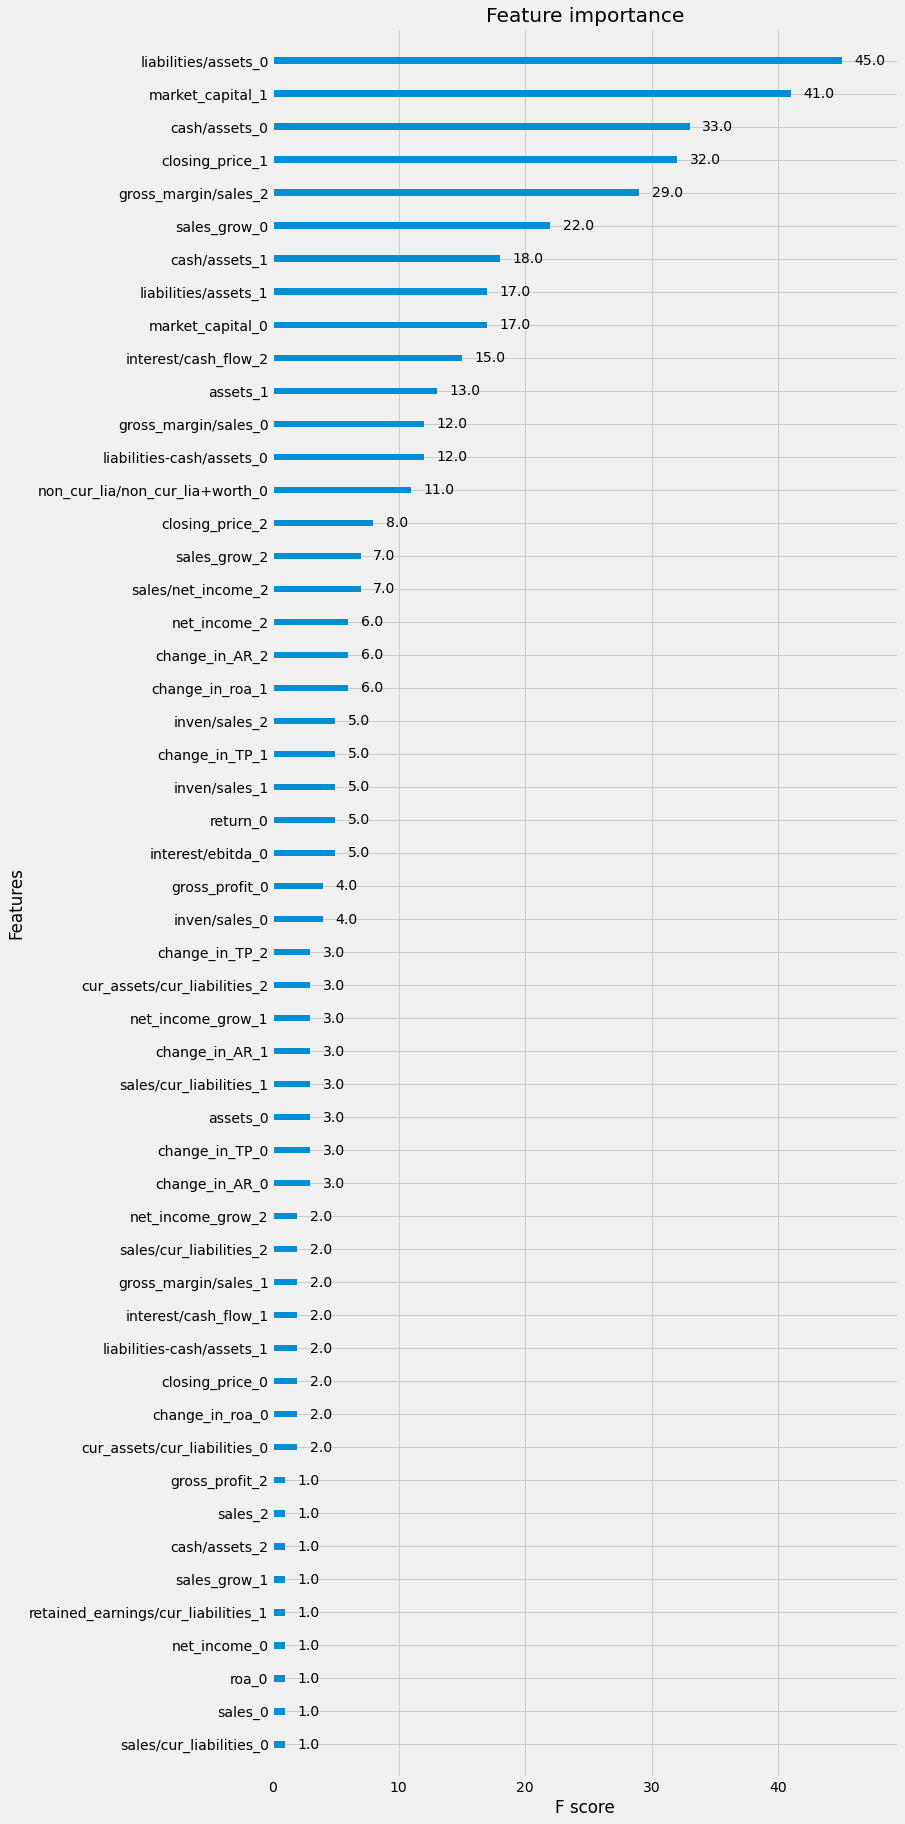

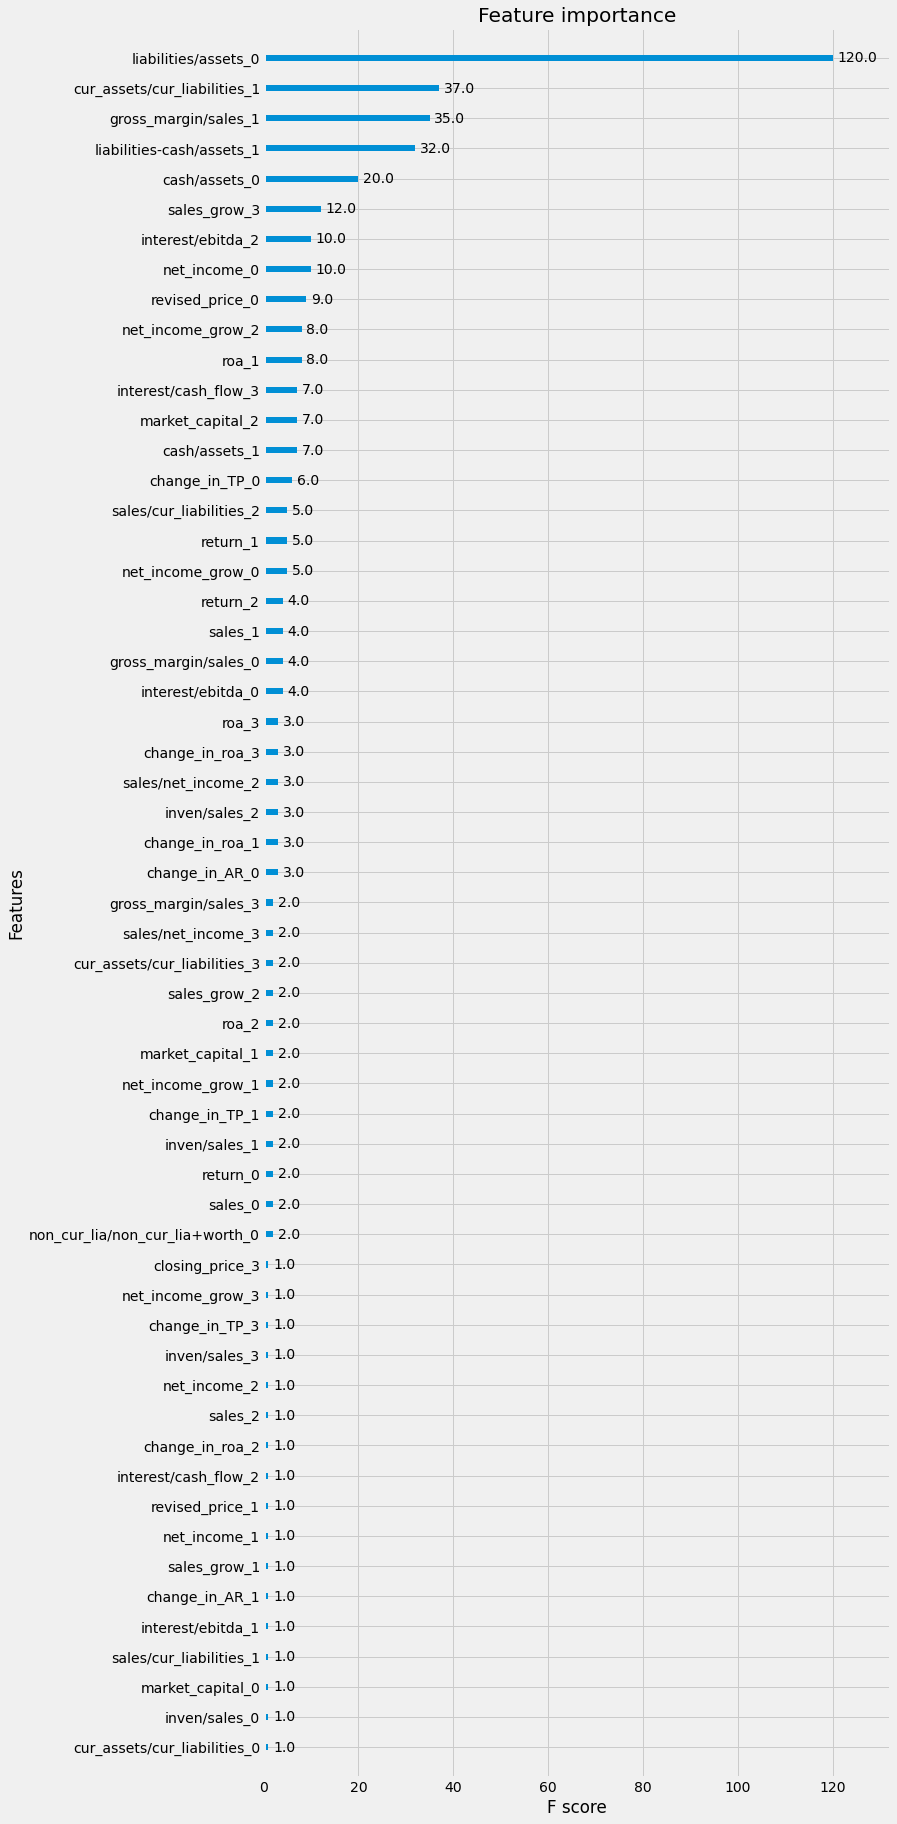

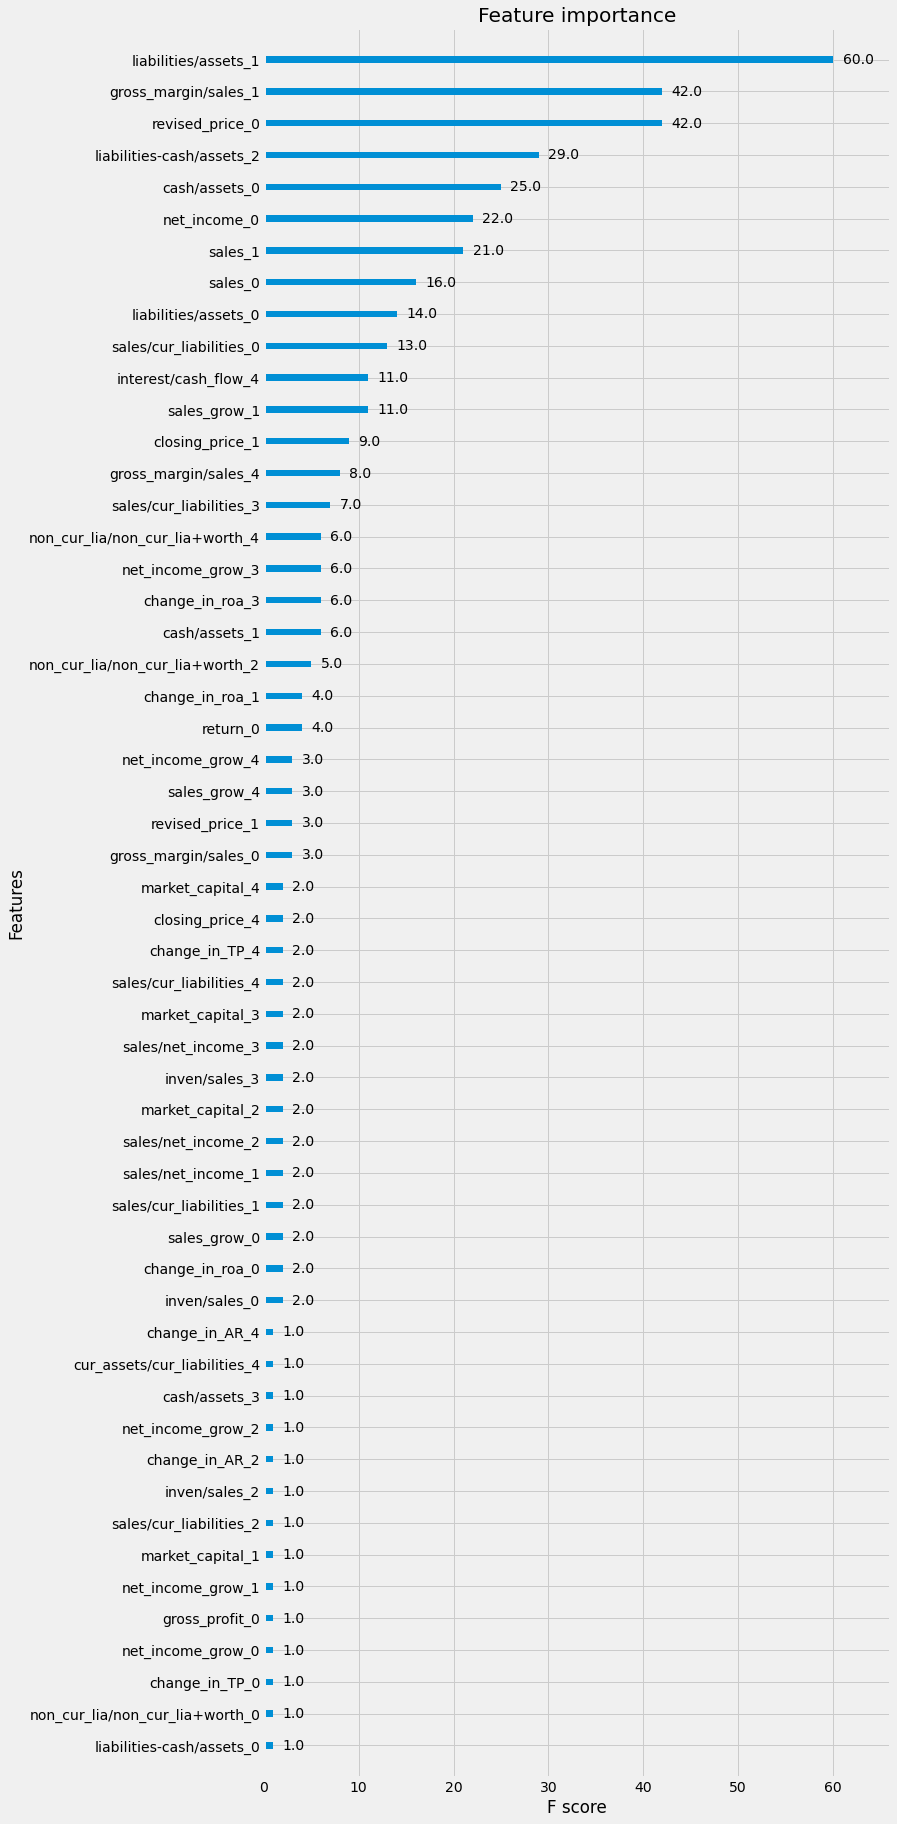

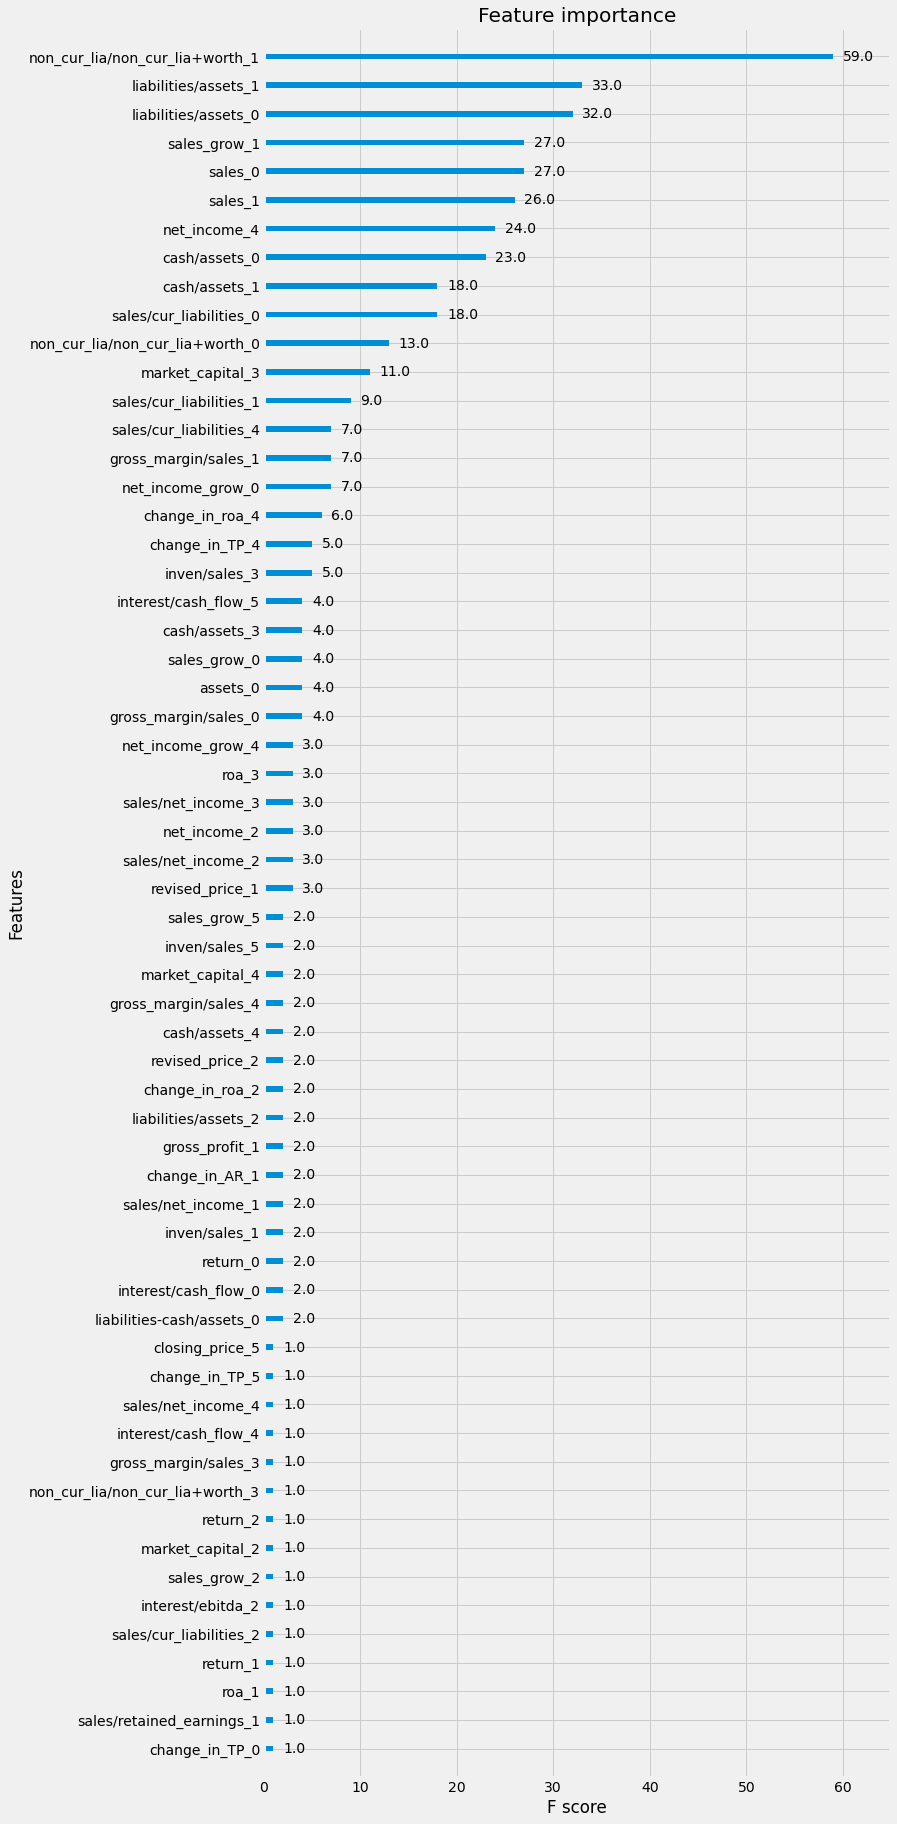

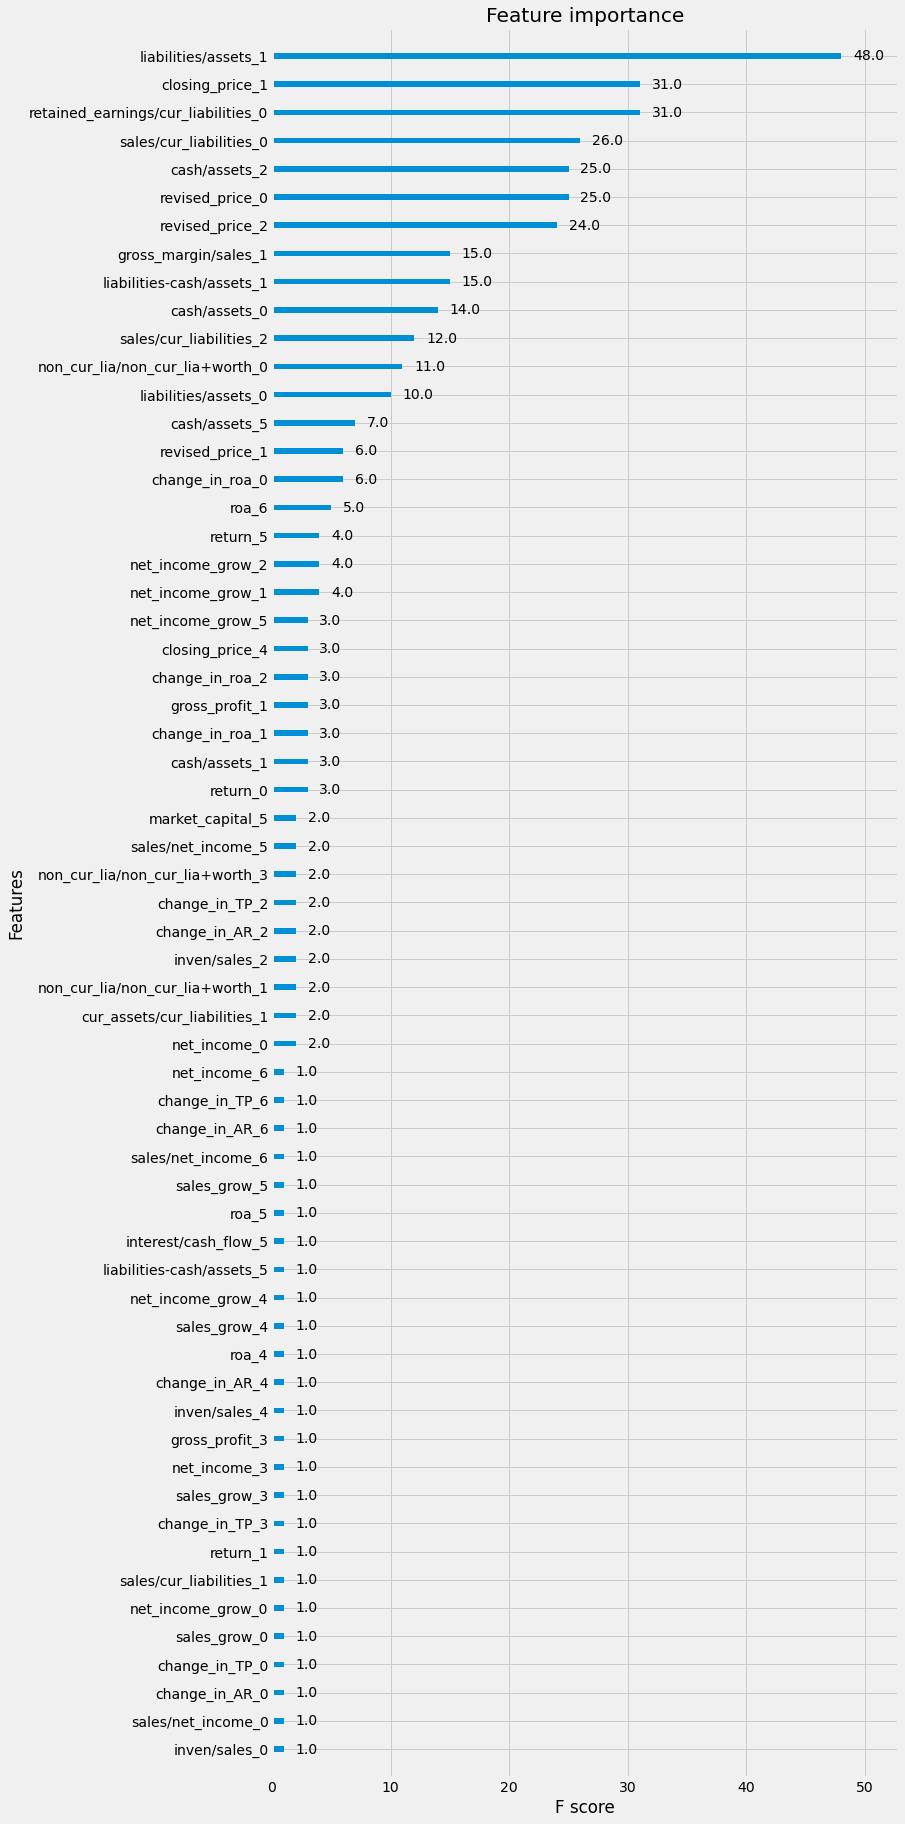

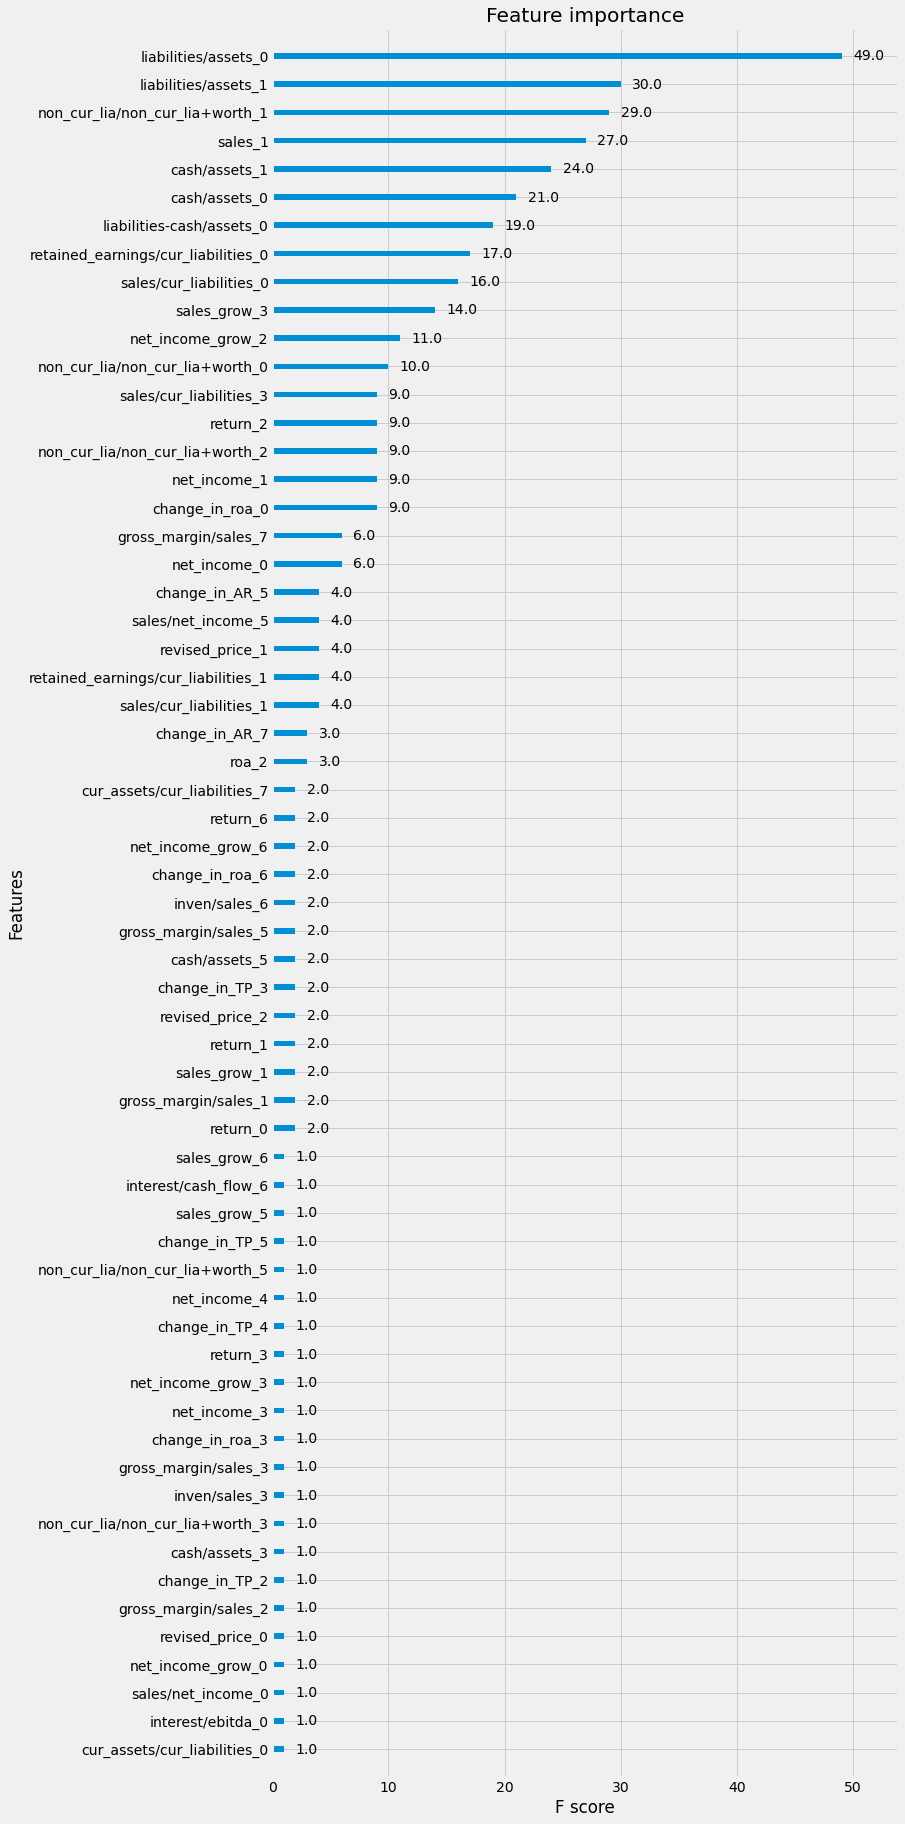

In [ ]:
#n별 정확도

result_score2_2 = pd.DataFrame()
term_list = []
score_list = []
list_0 = []
list_1 = []

for i in range(2, 8):
  term_list.append(str(i)+'년전까지')
  train_data2_2 = train_row_to_col(panel_a, i,'return') # i = 마지막연도+ n년전 자료까지

  X2_2 = train_data2_2.drop(['fnc_rsn_unlst_year','code_label'], axis=1)
  y2_2 = train_data2_2['fnc_rsn_unlst_year']

  result2_2 = xgb_smltn(X2_2, y2_2)


  ## 정확도
  score = accuracy_score(result2_2['y_pred'], result2_2['y_real'])
  score_list.append(round(score,4))

  ## 오답 개수
  cnt = result2_2.groupby(['y_real','y_pred'])[['y_pred']].count()
  if len(cnt.index) == 4:
    whole0_cnt = cnt.loc[(0,0),('y_pred')] + cnt.loc[(0,1),('y_pred')]
    wrng0_cnt = cnt.loc[(0,1),('y_pred')]
    list_0.append(round((wrng0_cnt/whole0_cnt)*100, 3))

    whole1_cnt = cnt.loc[(1,0),('y_pred')] + cnt.loc[(1,1),('y_pred')]
    wrng1_cnt = cnt.loc[(1,0),('y_pred')]
    list_1.append(round((wrng1_cnt/whole1_cnt)*100, 3))


  elif len(cnt.index) == 3: ## pred_y가 0인 값은 무조건 있으므로 (0, 1)와 (1, 1) 값이 없는 대부분
    if cnt.index.isin([(0, 1)])[1] == True: #(0, 0), (0, 1), (1, 0)
      whole0_cnt = cnt.loc[(0,0),('y_pred')] + cnt.loc[(0,1),('y_pred')]
      wrng0_cnt = cnt.loc[(0,1),('y_pred')]
      list_0.append(round((wrng0_cnt/whole0_cnt)*100, 3))

      all_wrng = 1
      list_1.append(round((all_wrng)*100, 3))
    else: #(0, 0), (1, 0), (1, 1)
      all_wrng = 1
      list_0.append(round((all_wrng)*100, 3))

      whole1_cnt = cnt.loc[(1,0),('y_pred')] + cnt.loc[(1,1),('y_pred')]
      wrng1_cnt = cnt.loc[(1,0),('y_pred')]
      list_1.append(round((wrng1_cnt/whole1_cnt)*100, 3))


  else: #(0, 0), (1, 0)
    all_wrng = 1
    all_crrct = 0
    list_0.append(round(all_crrct*100, 3))
    list_1.append(round(all_wrng*100, 3))

result_score2_2['term'] = term_list
result_score2_2['score'] = score_list
result_score2_2['real0_pred1(%)'] = list_0
result_score2_2['real1_pred0(%)'] = list_1

In [ ]:
result_score2_2

term   score  real0_pred1(%)  real1_pred0(%)
0  2년전까지  0.9893               0             100
1  3년전까지  0.9894               0             100
2  4년전까지  0.9896               0             100
3  5년전까지  0.9897               0             100
4  6년전까지  0.9902               0             100
5  7년전까지  0.9905               0             100

## (3) 데이터 변환: 변화율, 증가율

In [ ]:
def growth_rate(p0, p1):
  rate = (p1 - p0)/p0 #증가율 계산 = (현재시점-이전시점)/(이전시점)
  return rate

In [ ]:
def train_growth_rate(df, contained_year, contained_columns): #마지막연도 재무정보 기준 n년 전
  
  ## X
  X = pd.DataFrame()    

  for col in tqdm(df.loc[:,'cash/assets':contained_columns].columns):
    rate_list = []
    cor_list = []
    y_list = []
    
    for cor in df['code_label'].unique():
      df_cor_col = df[df['code_label']==cor][col].values
      df_cor_y = df[df['code_label']==cor]['fnc_rsn_unlst_year']

      if len(df_cor_col) > contained_year:
        y_list.extend(list(df_cor_y))
        
        for idx in range(len(df_cor_col)):
          if idx < contained_year:
            p0 = np.nan
            p1 = df_cor_col[idx]
          else:
            p0 = df_cor_col[idx-contained_year]
            p1 = df_cor_col[idx]

          rate = growth_rate(p0, p1)
          rate_list.append(rate)
          cor_list.append(cor)

    X['fnc_rsn_unlst_year'] = y_list
    X['code_label'] = cor_list
    X[col+'_'+'growth'] = rate_list

  return X

# train_data1_3 = train_growth_rate(panel_a, 4, 'return')
# train_data1_3.replace([np.inf, -np.inf], np.nan, inplace=True)
# print(train_data1_3.groupby('fnc_rsn_unlst_year')['fnc_rsn_unlst_year'].count())
# train_data1_3.apply(lambda x: np.isinf(x).sum())

[0]	validation_0-logloss:0.44774
[1]	validation_0-logloss:0.31284
[2]	validation_0-logloss:0.22837
[3]	validation_0-logloss:0.17235
[4]	validation_0-logloss:0.13425
[5]	validation_0-logloss:0.10753
[6]	validation_0-logloss:0.08895
[7]	validation_0-logloss:0.07555
[8]	validation_0-logloss:0.06632
[9]	validation_0-logloss:0.05959
[10]	validation_0-logloss:0.05482
[11]	validation_0-logloss:0.05123
[12]	validation_0-logloss:0.04909
[13]	validation_0-logloss:0.04733
[14]	validation_0-logloss:0.04603
[15]	validation_0-logloss:0.04529
[16]	validation_0-logloss:0.04488
[17]	validation_0-logloss:0.04442
[18]	validation_0-logloss:0.04425
[19]	validation_0-logloss:0.04426
[20]	validation_0-logloss:0.04410
[21]	validation_0-logloss:0.04400
[22]	validation_0-logloss:0.04387
[23]	validation_0-logloss:0.04374
[24]	validation_0-logloss:0.04389
[25]	validation_0-logloss:0.04371
[26]	validation_0-logloss:0.04354
[27]	validation_0-logloss:0.04353
[28]	validation_0-logloss:0.04358
[29]	validation_0-loglos

정확도: 0.9899733235212952


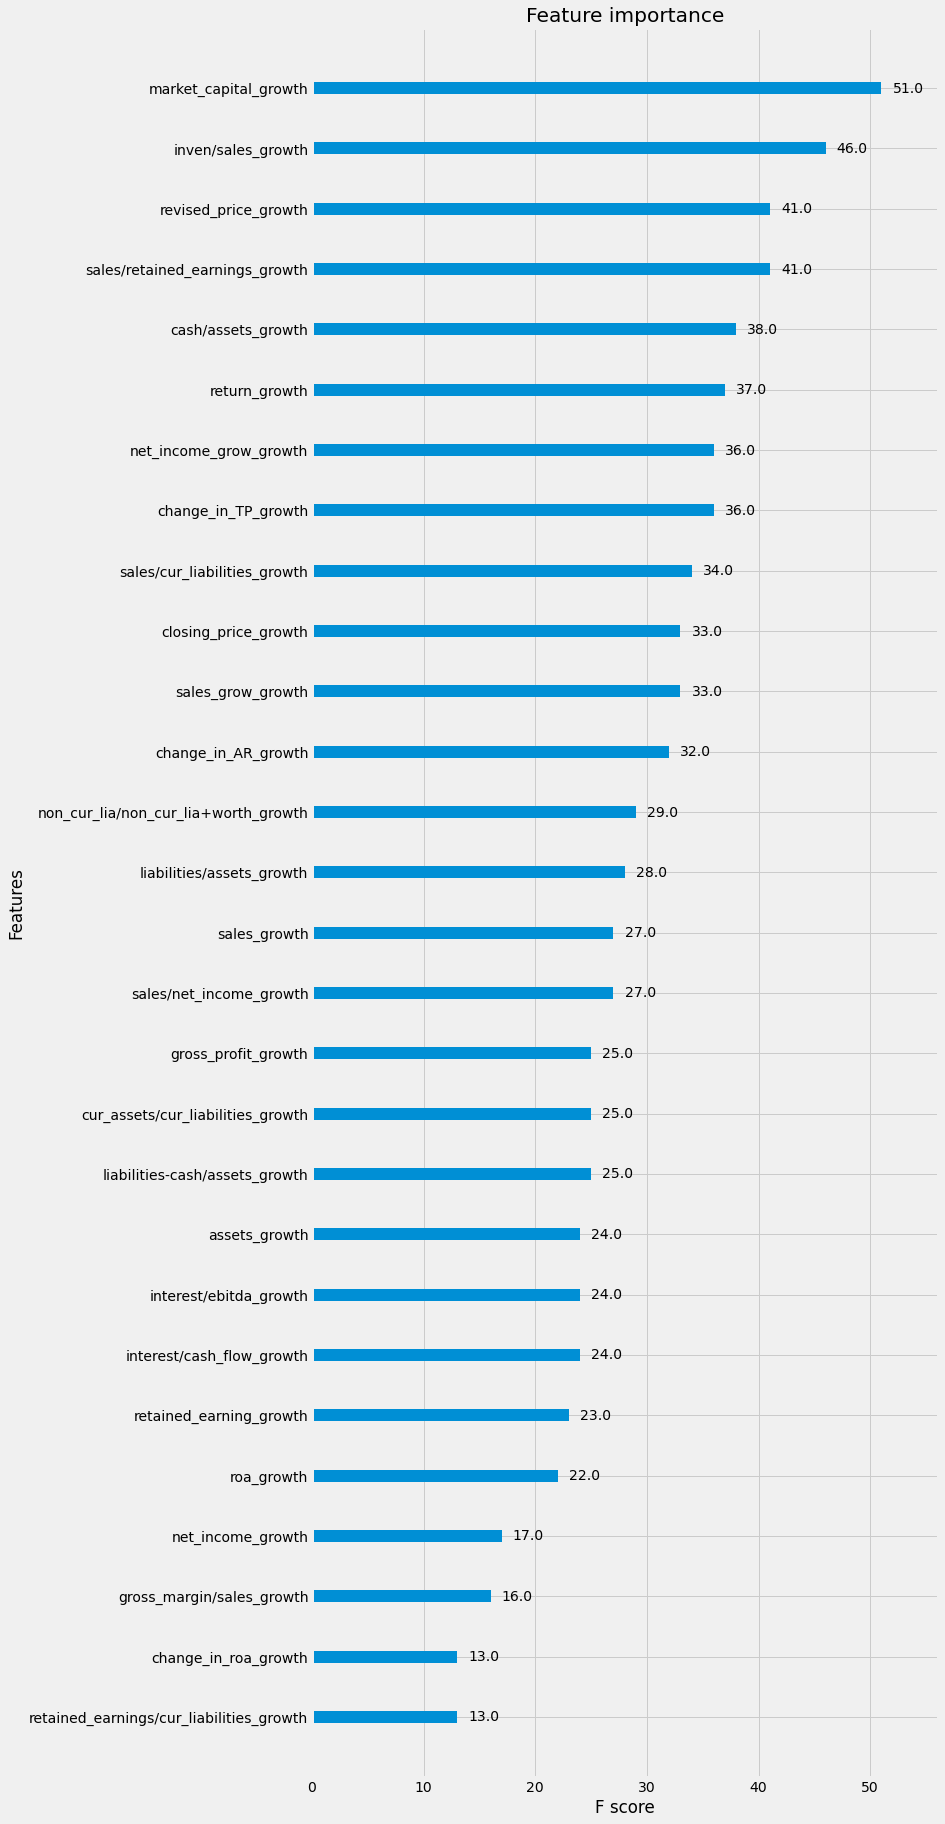

In [ ]:
X1_3 = train_data1_3.drop(['fnc_rsn_unlst_year', 'code_label'], axis=1)
y1_3 = train_data1_3['fnc_rsn_unlst_year']

result1_3 = xgb_smltn(X1_3, y1_3)

In [ ]:
print("정확도:",accuracy_score(result1_3['y_pred'], result1_3['y_real']))
result_count = pd.DataFrame(result1_3.groupby(['y_real','y_pred'])['y_pred'].count()).rename(columns={'y_pred':'count'}).reset_index()
print(result1_3.groupby(['y_real','y_pred'])['y_pred'].count(), '\n')
print('상장유지를 상장폐지로 예측:', result_count['count'][1], '/',result_count['count'][0]+result_count['count'][1])
print('상장폐지를 상장유지로 예측:',result_count['count'][2], '/',result_count['count'][2]+result_count['count'][3])
print(round(result_count['count'][1]/(result_count['count'][0]+result_count['count'][1]),4))
print(round(result_count['count'][2]/(result_count['count'][2]+result_count['count'][3]),4))

정확도: 0.9899733235212952
y_real  y_pred
0       0         10748
        1             7
1       0           102
        1            14
Name: y_pred, dtype: int64 

상장유지를 상장폐지로 예측: 7 / 10755
상장폐지를 상장유지로 예측: 102 / 116
0.0007
0.8793


100%|██████████| 29/29 [01:30<00:00,  3.11s/it]


[0]	validation_0-logloss:0.44798
[1]	validation_0-logloss:0.31283
[2]	validation_0-logloss:0.22841
[3]	validation_0-logloss:0.17254
[4]	validation_0-logloss:0.13434
[5]	validation_0-logloss:0.10765
[6]	validation_0-logloss:0.08891
[7]	validation_0-logloss:0.07559
[8]	validation_0-logloss:0.06619
[9]	validation_0-logloss:0.05937
[10]	validation_0-logloss:0.05456
[11]	validation_0-logloss:0.05115
[12]	validation_0-logloss:0.04883
[13]	validation_0-logloss:0.04732
[14]	validation_0-logloss:0.04604
[15]	validation_0-logloss:0.04534
[16]	validation_0-logloss:0.04470
[17]	validation_0-logloss:0.04437
[18]	validation_0-logloss:0.04426
[19]	validation_0-logloss:0.04425
[20]	validation_0-logloss:0.04397
[21]	validation_0-logloss:0.04384
[22]	validation_0-logloss:0.04374
[23]	validation_0-logloss:0.04360
[24]	validation_0-logloss:0.04364
[25]	validation_0-logloss:0.04373
[26]	validation_0-logloss:0.04367
[27]	validation_0-logloss:0.04367
[28]	validation_0-logloss:0.04355
[29]	validation_0-loglos

100%|██████████| 29/29 [01:23<00:00,  2.88s/it]


[0]	validation_0-logloss:0.44767
[1]	validation_0-logloss:0.31244
[2]	validation_0-logloss:0.22811
[3]	validation_0-logloss:0.17217
[4]	validation_0-logloss:0.13372
[5]	validation_0-logloss:0.10731
[6]	validation_0-logloss:0.08844
[7]	validation_0-logloss:0.07508
[8]	validation_0-logloss:0.06578
[9]	validation_0-logloss:0.05880
[10]	validation_0-logloss:0.05395
[11]	validation_0-logloss:0.05048
[12]	validation_0-logloss:0.04814
[13]	validation_0-logloss:0.04608
[14]	validation_0-logloss:0.04493
[15]	validation_0-logloss:0.04404
[16]	validation_0-logloss:0.04351
[17]	validation_0-logloss:0.04312
[18]	validation_0-logloss:0.04272
[19]	validation_0-logloss:0.04244
[20]	validation_0-logloss:0.04247
[21]	validation_0-logloss:0.04254
[22]	validation_0-logloss:0.04246
[23]	validation_0-logloss:0.04228
[24]	validation_0-logloss:0.04227
[25]	validation_0-logloss:0.04258
[26]	validation_0-logloss:0.04243
[27]	validation_0-logloss:0.04248
[28]	validation_0-logloss:0.04244
[29]	validation_0-loglos

100%|██████████| 29/29 [01:49<00:00,  3.78s/it]


[0]	validation_0-logloss:0.44774
[1]	validation_0-logloss:0.31284
[2]	validation_0-logloss:0.22837
[3]	validation_0-logloss:0.17235
[4]	validation_0-logloss:0.13425
[5]	validation_0-logloss:0.10753
[6]	validation_0-logloss:0.08895
[7]	validation_0-logloss:0.07555
[8]	validation_0-logloss:0.06632
[9]	validation_0-logloss:0.05959
[10]	validation_0-logloss:0.05482
[11]	validation_0-logloss:0.05123
[12]	validation_0-logloss:0.04909
[13]	validation_0-logloss:0.04733
[14]	validation_0-logloss:0.04603
[15]	validation_0-logloss:0.04529
[16]	validation_0-logloss:0.04488
[17]	validation_0-logloss:0.04442
[18]	validation_0-logloss:0.04425
[19]	validation_0-logloss:0.04426
[20]	validation_0-logloss:0.04410
[21]	validation_0-logloss:0.04400
[22]	validation_0-logloss:0.04387
[23]	validation_0-logloss:0.04374
[24]	validation_0-logloss:0.04389
[25]	validation_0-logloss:0.04371
[26]	validation_0-logloss:0.04354
[27]	validation_0-logloss:0.04353
[28]	validation_0-logloss:0.04358
[29]	validation_0-loglos

100%|██████████| 29/29 [01:25<00:00,  2.93s/it]


[0]	validation_0-logloss:0.44699
[1]	validation_0-logloss:0.31156
[2]	validation_0-logloss:0.22677
[3]	validation_0-logloss:0.17051
[4]	validation_0-logloss:0.13216
[5]	validation_0-logloss:0.10558
[6]	validation_0-logloss:0.08659
[7]	validation_0-logloss:0.07321
[8]	validation_0-logloss:0.06355
[9]	validation_0-logloss:0.05674
[10]	validation_0-logloss:0.05188
[11]	validation_0-logloss:0.04844
[12]	validation_0-logloss:0.04594
[13]	validation_0-logloss:0.04393
[14]	validation_0-logloss:0.04291
[15]	validation_0-logloss:0.04172
[16]	validation_0-logloss:0.04142
[17]	validation_0-logloss:0.04090
[18]	validation_0-logloss:0.04071
[19]	validation_0-logloss:0.04056
[20]	validation_0-logloss:0.04041
[21]	validation_0-logloss:0.04022
[22]	validation_0-logloss:0.04012
[23]	validation_0-logloss:0.03997
[24]	validation_0-logloss:0.03992
[25]	validation_0-logloss:0.03993
[26]	validation_0-logloss:0.03973
[27]	validation_0-logloss:0.03980
[28]	validation_0-logloss:0.03965
[29]	validation_0-loglos

100%|██████████| 29/29 [01:24<00:00,  2.93s/it]


[0]	validation_0-logloss:0.44684
[1]	validation_0-logloss:0.31118
[2]	validation_0-logloss:0.22607
[3]	validation_0-logloss:0.16979
[4]	validation_0-logloss:0.13117
[5]	validation_0-logloss:0.10429
[6]	validation_0-logloss:0.08508
[7]	validation_0-logloss:0.07159
[8]	validation_0-logloss:0.06194
[9]	validation_0-logloss:0.05486
[10]	validation_0-logloss:0.04965
[11]	validation_0-logloss:0.04606
[12]	validation_0-logloss:0.04350
[13]	validation_0-logloss:0.04173
[14]	validation_0-logloss:0.04029
[15]	validation_0-logloss:0.03947
[16]	validation_0-logloss:0.03890
[17]	validation_0-logloss:0.03843
[18]	validation_0-logloss:0.03794
[19]	validation_0-logloss:0.03754
[20]	validation_0-logloss:0.03743
[21]	validation_0-logloss:0.03720
[22]	validation_0-logloss:0.03695
[23]	validation_0-logloss:0.03671
[24]	validation_0-logloss:0.03668
[25]	validation_0-logloss:0.03663
[26]	validation_0-logloss:0.03664
[27]	validation_0-logloss:0.03649
[28]	validation_0-logloss:0.03652
[29]	validation_0-loglos

100%|██████████| 29/29 [01:29<00:00,  3.07s/it]


[0]	validation_0-logloss:0.44591
[1]	validation_0-logloss:0.30960
[2]	validation_0-logloss:0.22432
[3]	validation_0-logloss:0.16778
[4]	validation_0-logloss:0.12898
[5]	validation_0-logloss:0.10196
[6]	validation_0-logloss:0.08270
[7]	validation_0-logloss:0.06887
[8]	validation_0-logloss:0.05912
[9]	validation_0-logloss:0.05208
[10]	validation_0-logloss:0.04686
[11]	validation_0-logloss:0.04334
[12]	validation_0-logloss:0.04071
[13]	validation_0-logloss:0.03908
[14]	validation_0-logloss:0.03762
[15]	validation_0-logloss:0.03684
[16]	validation_0-logloss:0.03594
[17]	validation_0-logloss:0.03550
[18]	validation_0-logloss:0.03527
[19]	validation_0-logloss:0.03529
[20]	validation_0-logloss:0.03508
[21]	validation_0-logloss:0.03497
[22]	validation_0-logloss:0.03491
[23]	validation_0-logloss:0.03487
[24]	validation_0-logloss:0.03487
[25]	validation_0-logloss:0.03501
[26]	validation_0-logloss:0.03494
[27]	validation_0-logloss:0.03496
[28]	validation_0-logloss:0.03506
[29]	validation_0-loglos

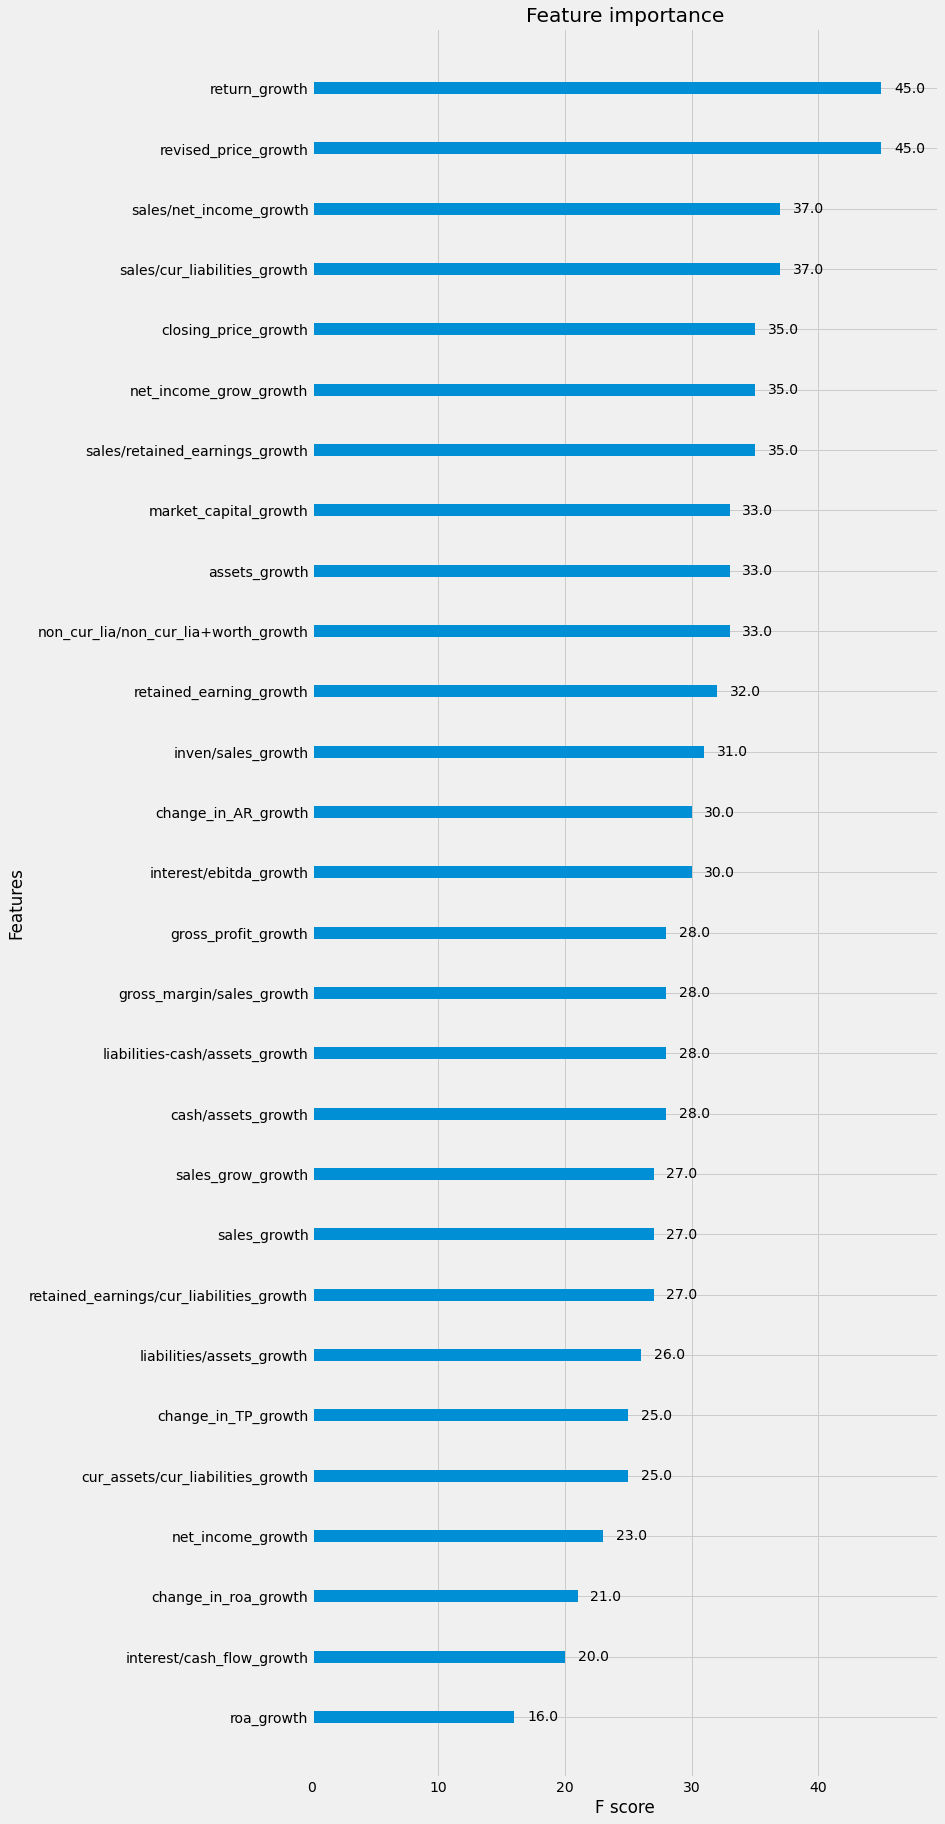

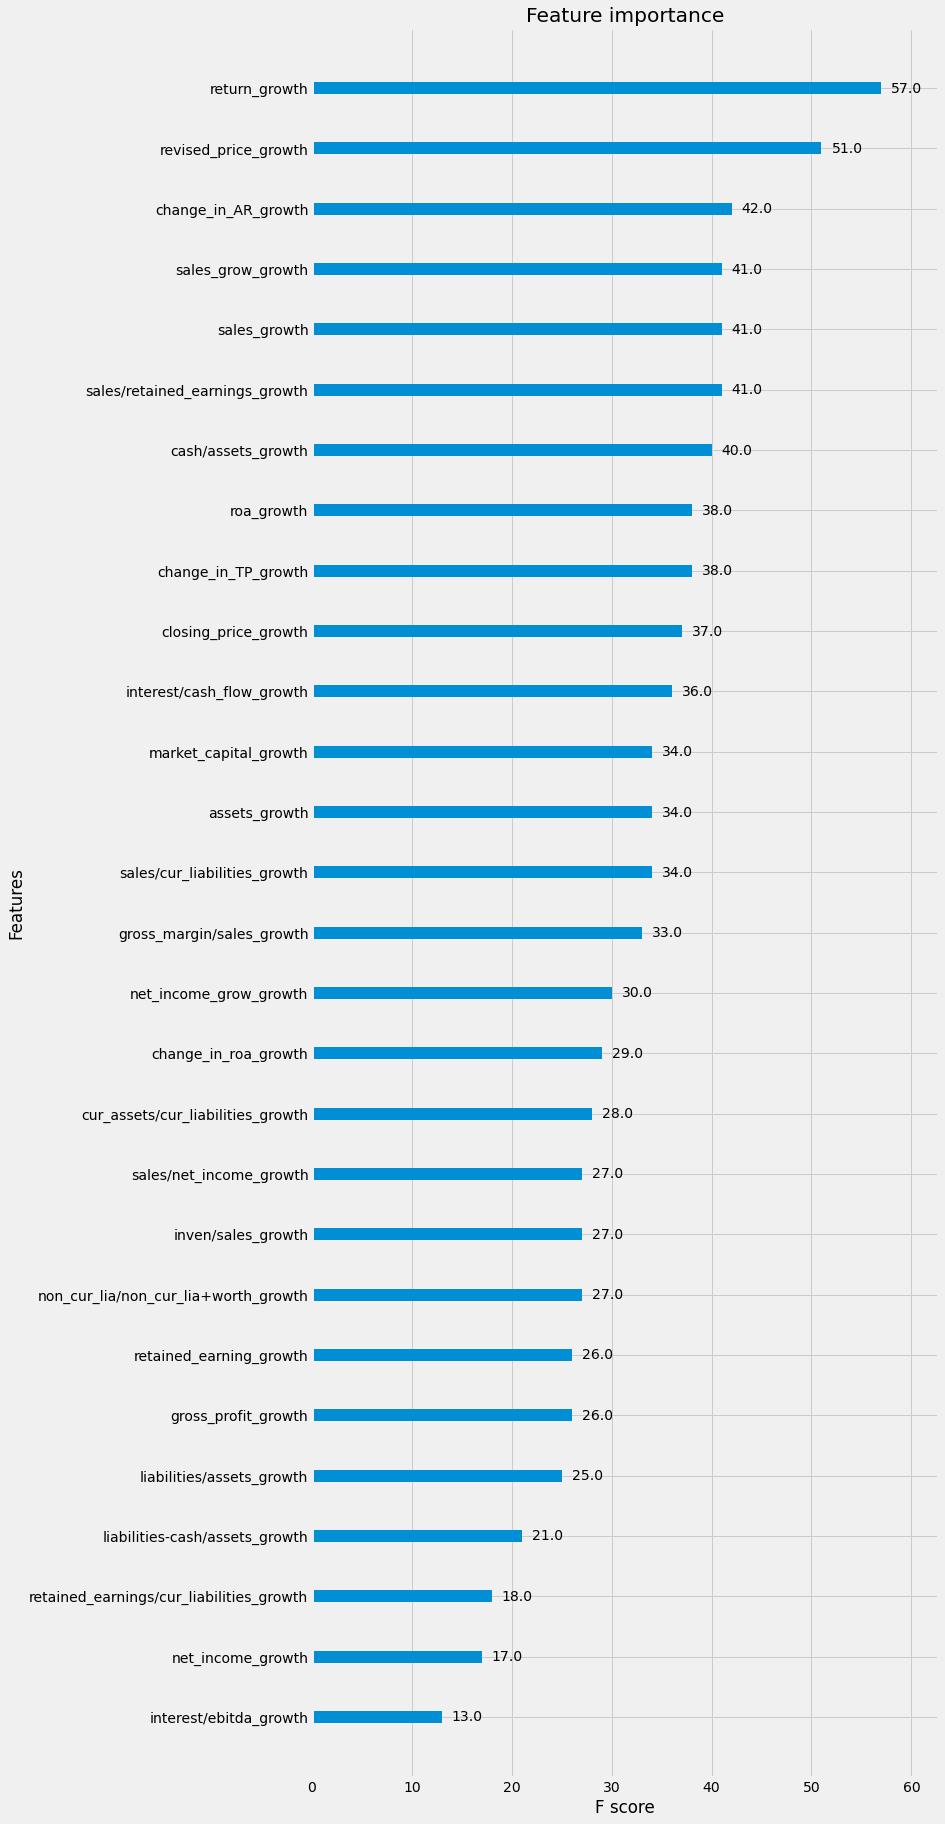

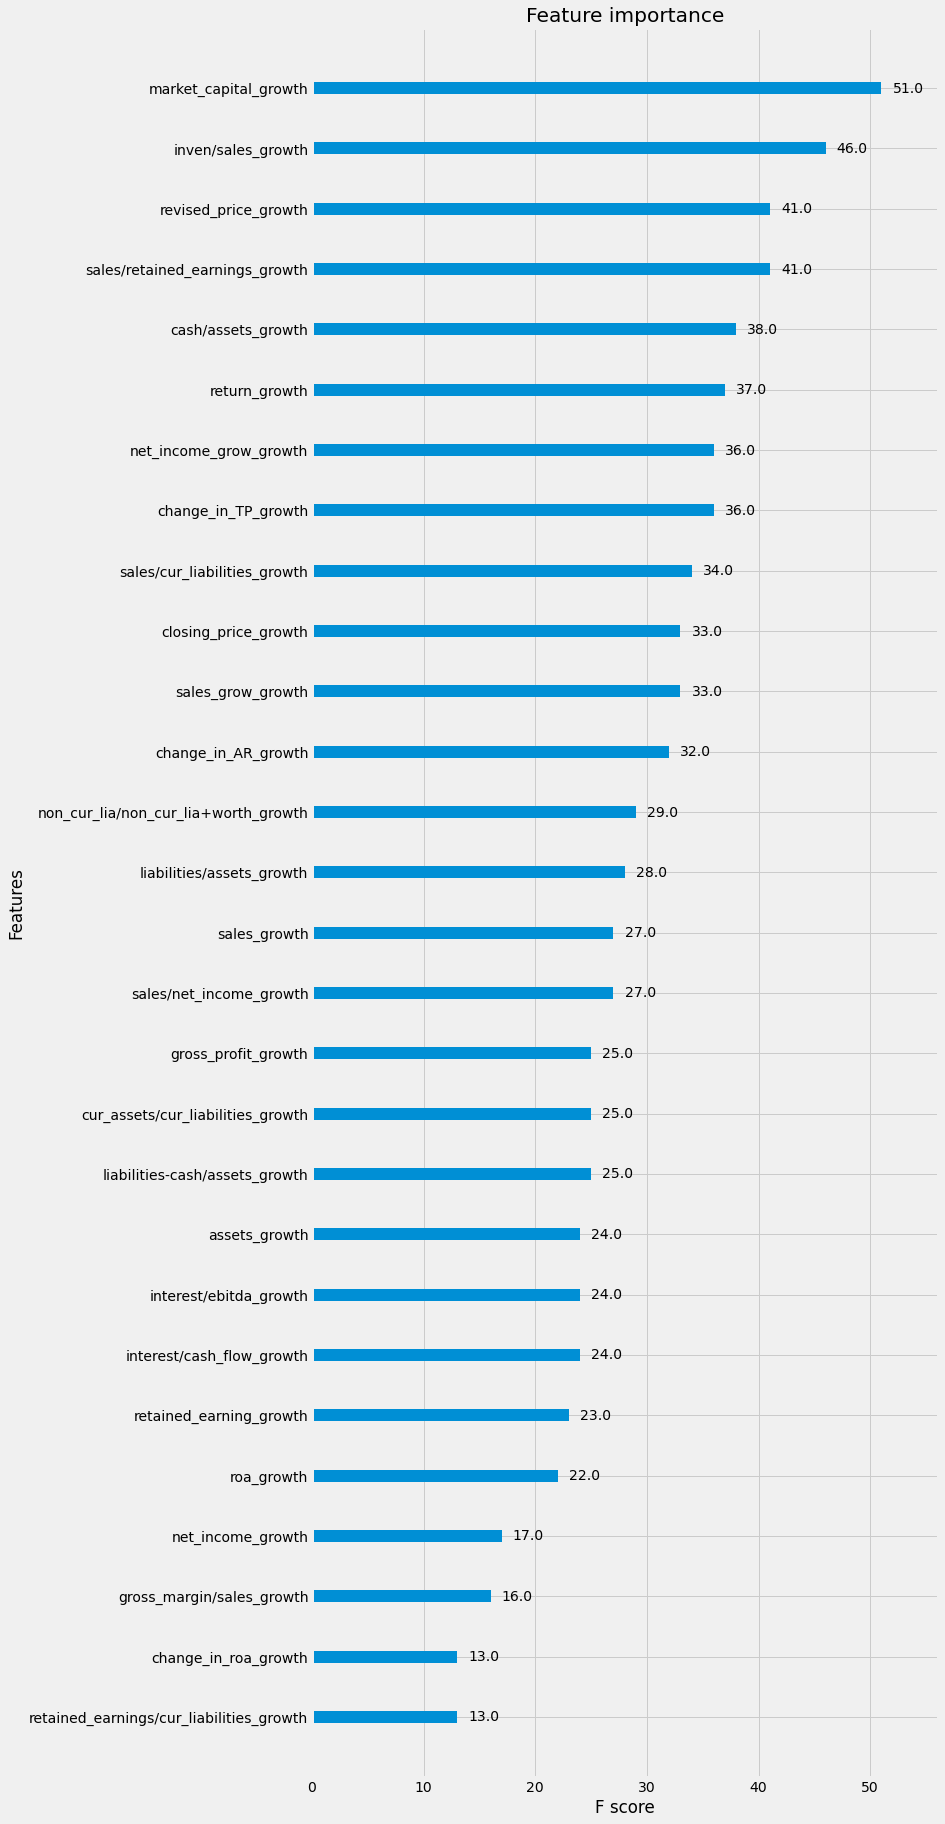

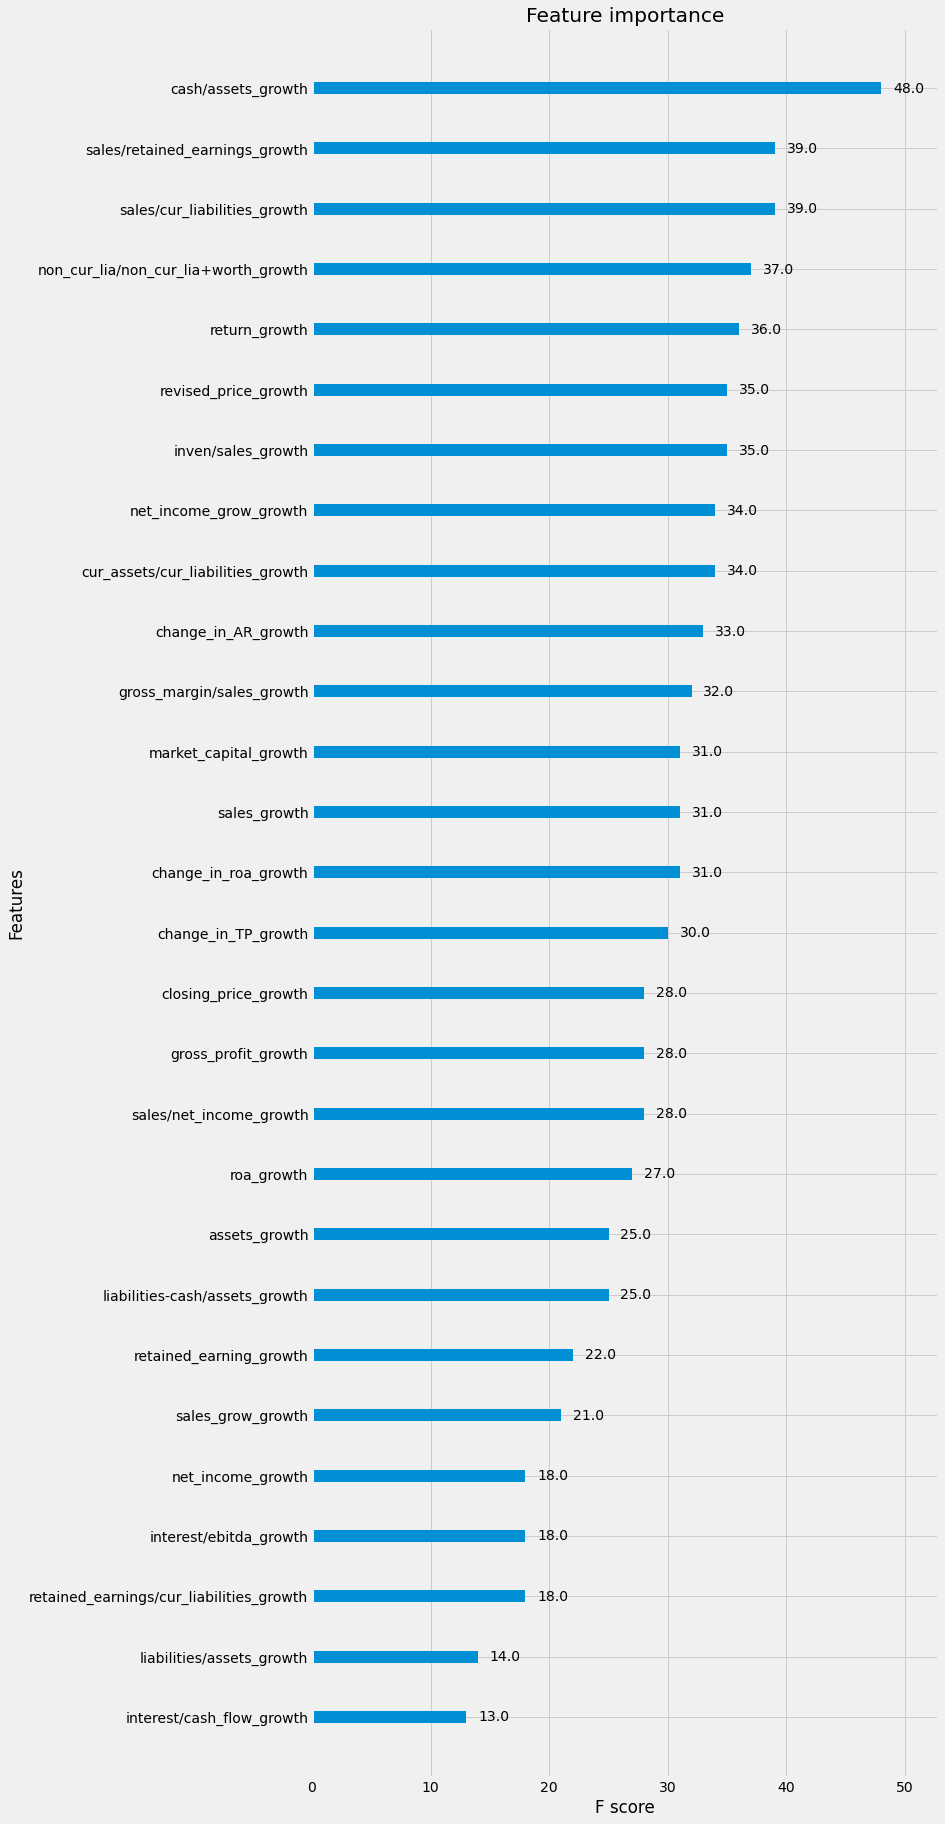

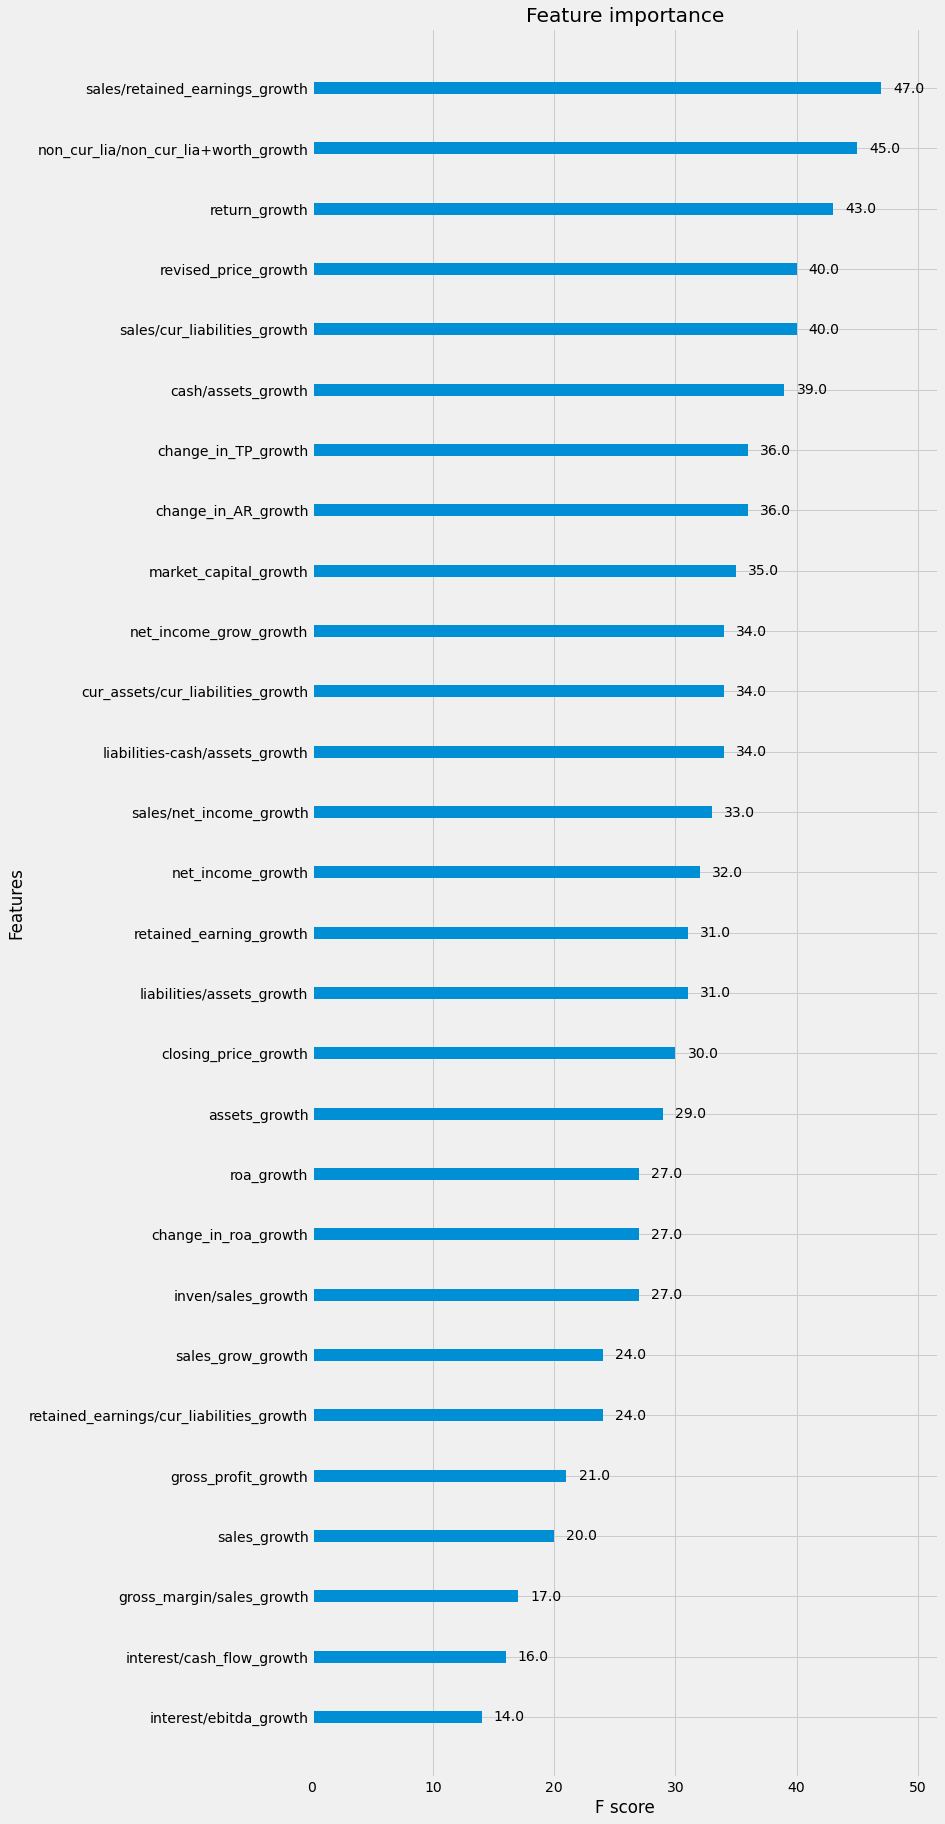

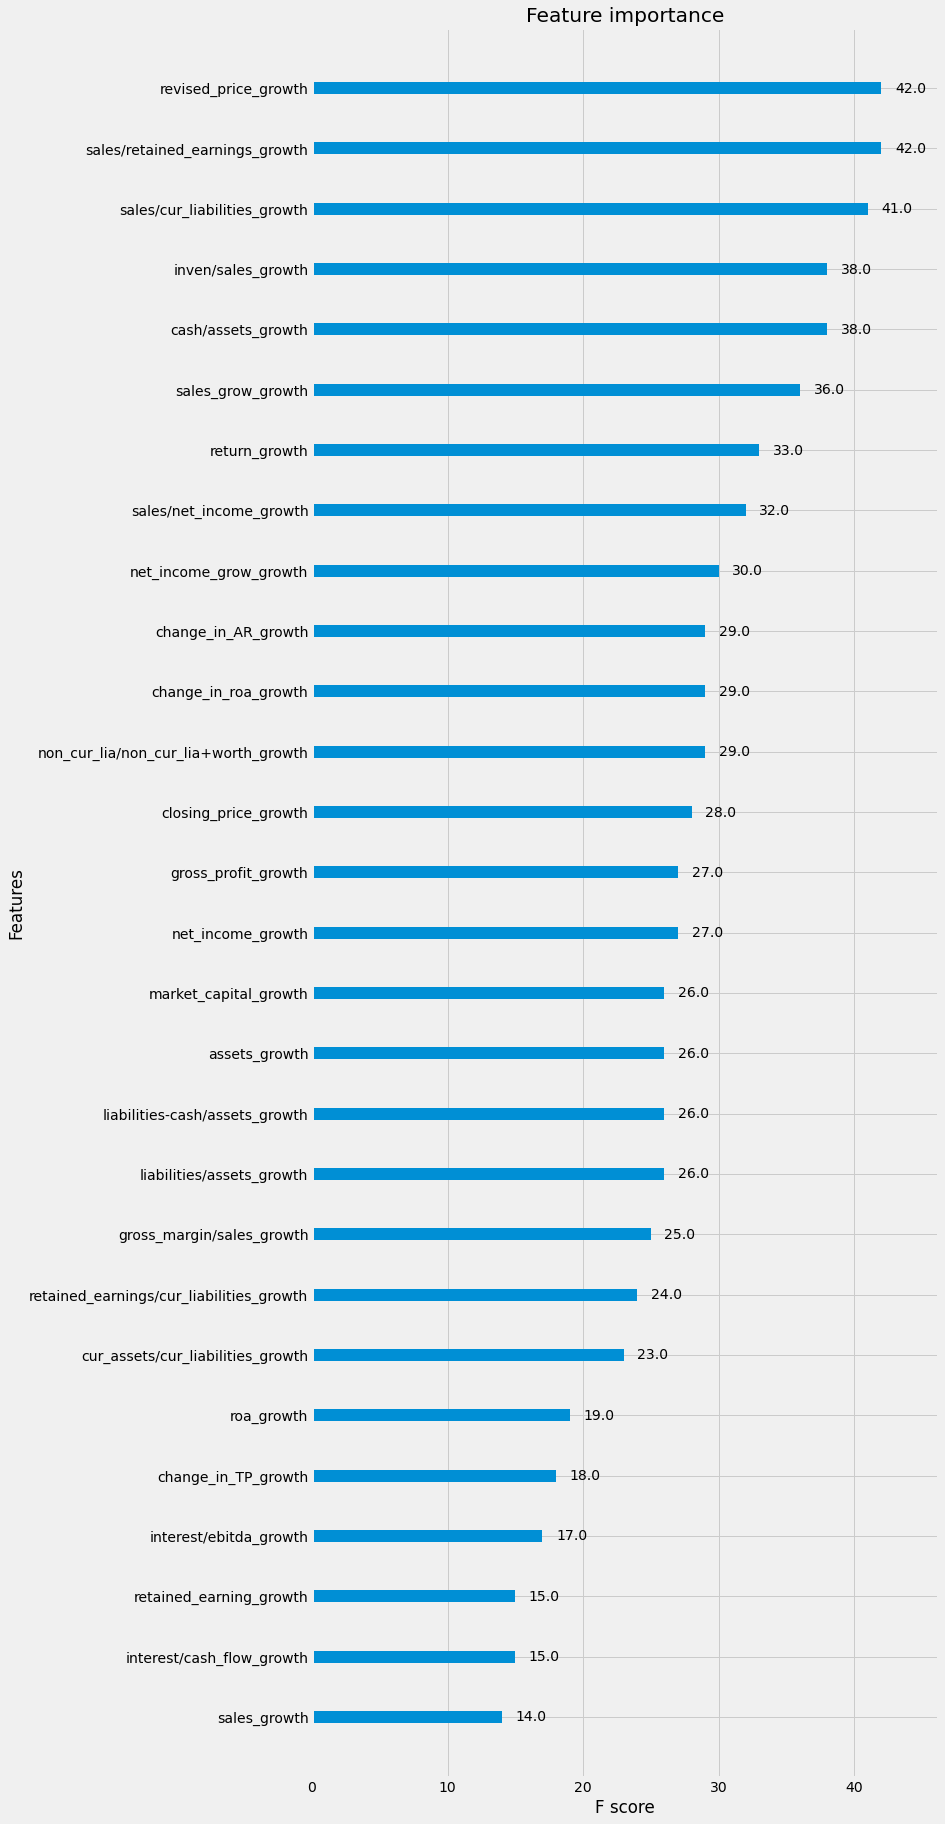

In [ ]:
## n별 정확도

result_score2_3 = pd.DataFrame()
term_list = []
score_list = []
list_0 = []
list_1 = []

for i in range(2, 8):
  term_list.append(str(i)+'년전까지')
  train_data2_3 = train_growth_rate(panel_a, i,'return') # i = 마지막연도+ n년전 자료까지
  train_data2_3.replace([np.inf, -np.inf], np.nan, inplace=True)

  X2_3 = train_data2_3.drop(['fnc_rsn_unlst_year', 'code_label'], axis=1)
  y2_3 = train_data2_3['fnc_rsn_unlst_year']

  result2_3 = xgb_smltn(X2_3, y2_3)
  # try:
  #   result3_2 = xgb_smltn(X3_2, y3_2)
  # except:
  #   break
  #   print("the resulting train set will be empty. 0이상 "+str(i)+"이하로 설정하세요.")

  ## 정확도
  score = accuracy_score(result2_3['y_pred'], result2_3['y_real'])
  score_list.append(round(score,4))

  ## 오답 개수
  cnt = result2_3.groupby(['y_real','y_pred'])[['y_pred']].count()
  if len(cnt.index) == 4:
    whole0_cnt = cnt.loc[(0,0),('y_pred')] + cnt.loc[(0,1),('y_pred')]
    wrng0_cnt = cnt.loc[(0,1),('y_pred')]
    list_0.append(round((wrng0_cnt/whole0_cnt)*100, 3))

    whole1_cnt = cnt.loc[(1,0),('y_pred')] + cnt.loc[(1,1),('y_pred')]
    wrng1_cnt = cnt.loc[(1,0),('y_pred')]
    list_1.append(round((wrng1_cnt/whole1_cnt)*100, 3))


  elif len(cnt.index) == 3: ## pred_y가 0인 값은 무조건 있으므로 (0, 1)와 (1, 1) 값이 없는 대부분
    if cnt.index.isin([(0, 1)])[1] == True: #(0, 0), (0, 1), (1, 0)
      whole0_cnt = cnt.loc[(0,0),('y_pred')] + cnt.loc[(0,1),('y_pred')]
      wrng0_cnt = cnt.loc[(0,1),('y_pred')]
      list_0.append(round((wrng0_cnt/whole0_cnt)*100, 3))

      all_wrng = 1
      list_1.append(round((all_wrng)*100, 3))
    else: #(0, 0), (1, 0), (1, 1)
      all_wrng = 1
      list_0.append(round((all_wrng)*100, 3))

      whole1_cnt = cnt.loc[(1,0),('y_pred')] + cnt.loc[(1,1),('y_pred')]
      wrng1_cnt = cnt.loc[(1,0),('y_pred')]
      list_1.append(round((wrng1_cnt/whole1_cnt)*100, 3))


  else: #(0, 0), (1, 0)
    all_wrng = 1
    all_crrct = 0
    list_0.append(round(all_crrct*100, 3))
    list_1.append(round(all_wrng*100, 3))

result_score2_3['term'] = term_list
result_score2_3['score'] = score_list
result_score2_3['real0_pred1(%)'] = list_0
result_score2_3['real1_pred0(%)'] = list_1

In [ ]:
result_score2_3

term   score  real0_pred1(%)  real1_pred0(%)
0  2년전까지  0.9885           0.157          90.833
1  3년전까지  0.9885           0.148          91.597
2  4년전까지  0.9900           0.065          87.931
3  5년전까지  0.9891           0.112          95.455
4  6년전까지  0.9896           0.132          92.381
5  7년전까지  0.9907           0.048          96.875

## (4) 데이터 변환: 최소제곱법 기반 지수함수 기울기

In [ ]:
def non_linear_least_square(x,Y):
    b = (np.mean(x)*np.mean(Y) - np.mean(x*Y))/(np.mean(x)*np.mean(x)-np.mean(x*x))
    A = np.mean(Y)-np.mean(x)*b
    a = np.exp(A)
    return a,b

In [ ]:
def train_non_linear(df, contained_year, contained_columns):
  
  ## X
  X = pd.DataFrame()

  for col in tqdm(df.loc[:,'cash/assets':contained_columns].columns):
    a_list = []
    b_list = []
    cor_list = []
    y_list = []

    for cor in df['code_label'].unique():
      df_cor = df[df['code_label']==cor].reset_index(drop=True)
      df_cor_y = df_cor['fnc_rsn_unlst_year']

      if len(df_cor) >= contained_year:
        for idx, y in enumerate(df_cor_y):
          df_cor_col = df_cor.loc[idx-contained_year:idx, [col]]

          if len(df_cor_col) < contained_year+1: #contained_year이 없는 시점인 경우 ex.2년전+현재idx
            nan_before = pd.DataFrame(columns=[col], index=range(contained_year-idx))
            df_cor_col = pd.concat([nan_before, df_cor_col], axis=0).reset_index(drop=True)

          # print(df_cor_col[col].values.astype(float))
          x = np.array([inx for inx in range(len(df_cor_col[col].values))])
          Y = np.log((df_cor_col[col].values.astype(float)))

          a,b = non_linear_least_square(x,Y)

          cor_list.append(cor)
          a_list.append(a)
          b_list.append(b)
          y_list.append(y)

    X[col+'_'+'a'] = a_list
    X[col+'_'+'b'] = b_list

  X['code_label'] = cor_list
  X['fnc_rsn_unlst_year'] = y_list

  return X

# train_data1_4 = train_non_linear(panel_a, 2, 'return') 

In [ ]:
# print(train_data1_4.groupby('fnc_rsn_unlst_year')['fnc_rsn_unlst_year'].count())

# X1_4 = train_data1_4.drop(['fnc_rsn_unlst_year', 'code_label'], axis=1)
# y1_4 = train_data1_4['fnc_rsn_unlst_year']

# result1_4 = xgb_smltn(X1_4, y1_4)

In [ ]:
# print("정확도:",accuracy_score(result1_4['y_pred'], result1_4['y_real']))
# result_count = pd.DataFrame(result1_4.groupby(['y_real','y_pred'])['y_pred'].count()).rename(columns={'y_pred':'count'}).reset_index()
# print(result1_4.groupby(['y_real','y_pred'])['y_pred'].count(), '\n')
# print('상장폐지를 상장유지로 예측:', result_count['count'][1], '/',result_count['count'][0]+result_count['count'][1])
# print('상장유지를 상장폐지로 예측:',result_count['count'][2], '/',result_count['count'][2]+result_count['count'][3])
# print(round(result_count['count'][1]/(result_count['count'][0]+result_count['count'][1]),4))
# print(round(result_count['count'][2]/(result_count['count'][2]+result_count['count'][3]),4))

y_real  y_pred
0       0         10832
        1             6
1       0            95
        1            10
Name: y_pred, dtype: int64 

상장폐지를 상장유지로 예측: 6 / 10838
상장유지를 상장폐지로 예측: 95 / 105
0.0006
0.9048


In [ ]:
result_score2_4 = pd.DataFrame()
term_list = []
score_list = []
list_0 = []
list_1 = []

for i in range(2, 8):
  term_list.append(str(i)+'년전까지')
  train_data2_4 = train_growth_rate(panel_a, i,'return') # i = 마지막연도+ n년전 자료까지
  train_data2_4.replace([np.inf, -np.inf], np.nan, inplace=True)

  X2_4 = train_data2_4.drop(['fnc_rsn_unlst_year', 'code_label'], axis=1)
  y2_4 = train_data2_4['fnc_rsn_unlst_year']

  result2_4 = xgb_smltn(X2_4, y2_4)
  # try:
  #   result3_2 = xgb_smltn(X3_2, y3_2)
  # except:
  #   break
  #   print("the resulting train set will be empty. 0이상 "+str(i)+"이하로 설정하세요.")

  ## 정확도
  score = accuracy_score(result2_4['y_pred'], result2_4['y_real'])
  score_list.append(round(score,4))

  ## 오답 개수
  cnt = result2_4.groupby(['y_real','y_pred'])[['y_pred']].count()
  if len(cnt.index) == 4:
    whole0_cnt = cnt.loc[(0,0),('y_pred')] + cnt.loc[(0,1),('y_pred')]
    wrng0_cnt = cnt.loc[(0,1),('y_pred')]
    list_0.append(round((wrng0_cnt/whole0_cnt)*100, 3))

    whole1_cnt = cnt.loc[(1,0),('y_pred')] + cnt.loc[(1,1),('y_pred')]
    wrng1_cnt = cnt.loc[(1,0),('y_pred')]
    list_1.append(round((wrng1_cnt/whole1_cnt)*100, 3))


  elif len(cnt.index) == 3: ## pred_y가 0인 값은 무조건 있으므로 (0, 1)와 (1, 1) 값이 없는 대부분
    if cnt.index.isin([(0, 1)])[1] == True: #(0, 0), (0, 1), (1, 0)
      whole0_cnt = cnt.loc[(0,0),('y_pred')] + cnt.loc[(0,1),('y_pred')]
      wrng0_cnt = cnt.loc[(0,1),('y_pred')]
      list_0.append(round((wrng0_cnt/whole0_cnt)*100, 3))

      all_wrng = 1
      list_1.append(round((all_wrng)*100, 3))
    else: #(0, 0), (1, 0), (1, 1)
      all_wrng = 1
      list_0.append(round((all_wrng)*100, 3))

      whole1_cnt = cnt.loc[(1,0),('y_pred')] + cnt.loc[(1,1),('y_pred')]
      wrng1_cnt = cnt.loc[(1,0),('y_pred')]
      list_1.append(round((wrng1_cnt/whole1_cnt)*100, 3))


  else: #(0, 0), (1, 0)
    all_wrng = 1
    all_crrct = 0
    list_0.append(round(all_crrct*100, 3))
    list_1.append(round(all_wrng*100, 3))

result_score2_4['term'] = term_list
result_score2_4['score'] = score_list
result_score2_4['real0_pred1(%)'] = list_0
result_score2_4['real1_pred0(%)'] = list_1

# #3. 최적 데이터 형태 및 범위 조합한 모델

## (1) row로 나열(n=2) + 증가율(n=4)

In [ ]:
def add_year(panel, train):

  year_list=[]

  for cor in train['code_label'].unique():
    panel_year = panel[panel['code_label']==cor]['year']

    year_list.extend(panel_year)

  train['year'] = year_list
  return train

# train_data1_2 = add_year(panel_a, train_data1_2)
# train_data1_3 = add_year(panel_a, train_data1_3)
# train_data1_4 = add_year(panel_a, train_data1_4)

In [ ]:
union_train1 = train_data1_2.merge(train_data1_3.drop(['fnc_rsn_unlst_year'], axis=1), how='inner',on=['code_label', 'year'])
# union_train1[union_train1['fnc_rsn_unlst_year_x']!=union_train1['fnc_rsn_unlst_year_y']] ## 두 train의 종속변수는 일치하므로 하나로 통일
union_train1[['cash/assets_0', 'cash/assets_1', 'cash/assets_2','cash/assets_growth', 'return_growth', 'fnc_rsn_unlst_year', 'code_label']]

cash/assets_0  cash/assets_1  cash/assets_2  cash/assets_growth  \
0                NaN            NaN       0.026243                 NaN   
1                NaN       0.026243       0.011561                 NaN   
2           0.026243       0.011561       0.026253                 NaN   
3           0.011561       0.026253       0.033530                 NaN   
4           0.026253       0.033530       0.022999           -0.123599   
...              ...            ...            ...                 ...   
54347            NaN            NaN       0.026243                 NaN   
54348            NaN       0.026243       0.011561                 NaN   
54349       0.026243       0.011561       0.026253                 NaN   
54350       0.011561       0.026253       0.033530                 NaN   
54351       0.026253       0.033530       0.022999            0.135113   

       return_growth  fnc_rsn_unlst_year  code_label  
0                NaN                   0        5930  
1                NaN                   0        5930  
2                NaN                   0        5930  
3                NaN                   0        5930  
4                NaN                   0        5930  
...              ...                 ...         ...  
54347            NaN                   0      950180  
54348            NaN                   0      950180  
54349            NaN                   0      950180  
54350            NaN                   0      950180  
54351            NaN                   0      950180  

[54352 rows x 7 columns]

In [ ]:
union_train1.replace([np.inf, -np.inf], np.nan, inplace=True)
print(union_train1.groupby(['fnc_rsn_unlst_year'])['fnc_rsn_unlst_year'].count())
union_train1.apply(lambda x: np.isinf(x).sum())

fnc_rsn_unlst_year
0    53773
1      579
Name: fnc_rsn_unlst_year, dtype: int64


cash/assets_0                   0
liabilities/assets_0            0
liabilities-cash/assets_0       0
sales/cur_liabilities_0         0
cur_assets/cur_liabilities_0    0
                               ..
retained_earning_growth         0
closing_price_growth            0
revised_price_growth            0
market_capital_growth           0
return_growth                   0
Length: 119, dtype: int64

In [ ]:
def train_last_grwth(df): #주식 포함

  train_row_to_col_data = train_row_to_col(df, 2, 'return')
  train_growth_data = train_growth_rate(df, 4, 'return')
  
  train_row_to_col_data = add_year(panel_a, train_row_to_col_data)
  train_growth_data = add_year(panel_a, train_growth_data)

  result = train_row_to_col_data.merge(train_growth_data.drop(['fnc_rsn_unlst_year'], axis=1), how='inner',on=['code_label', 'year'])
  result.replace([np.inf, -np.inf], np.nan, inplace=True)

  return result
  
union_train1 = train_last_grwth(panel_a)

100%|██████████| 29/29 [00:58<00:00,  2.02s/it]


In [ ]:
X4_1 = union_train1.drop(['code_label', 'year', 'fnc_rsn_unlst_year'], axis=1)
y4_1 = union_train1['fnc_rsn_unlst_year']

union_result4_1 = xgb_smltn(X4_1, y4_1)

In [ ]:
print("정확도:",accuracy_score(union_result4_1['y_pred'], union_result4_1['y_real']))

result_count = pd.DataFrame(union_result4_1.groupby(['y_real','y_pred'])['y_pred'].count()).rename(columns={'y_pred':'count'}).reset_index()
print(union_result4_1.groupby(['y_real','y_pred'])['y_pred'].count(), '\n')
print('상장유지를 상장폐지로 예측:', result_count['count'][1], '/',result_count['count'][0]+result_count['count'][1])
print('상장폐지를 상장유지로 예측:',result_count['count'][2], '/',result_count['count'][2]+result_count['count'][3])
print(round(result_count['count'][1]/(result_count['count'][0]+result_count['count'][1]),4))
print(round(result_count['count'][2]/(result_count['count'][2]+result_count['count'][3]),4))

정확도: 0.9896973599484868
y_real  y_pred
0       0         10747
        1             8
1       0           104
        1            12
Name: y_pred, dtype: int64 

상장유지를 상장폐지로 예측: 8 / 10755
상장폐지를 상장유지로 예측: 104 / 116
0.0007
0.8966


## (2) row로 나열(n=2) + 지수함수(n=2)

In [ ]:
def train_last_non_lnr(df):

  train_row_to_col_data = train_row_to_col(df, 2, 'return')
  train_non_linear_data = train_non_linear(df, 2, 'return')

  result = train_row_to_col_data.merge(train_non_linear_data, how='outer',on='code_label')

  return result
  
# union_train2 = train_last_non_lnr(panel_a)

  0%|          | 0/30 [00:00<?, ?it/s]<ipython-input-30-649cbbb9e786>:20: RuntimeWarning: divide by zero encountered in log
  Y = np.log(y)
<ipython-input-29-77dc735660f7>:2: RuntimeWarning: invalid value encountered in double_scalars
  b = (np.mean(x)*np.mean(Y) - np.mean(x*Y))/(np.mean(x)*np.mean(x)-np.mean(x*x))
<ipython-input-29-77dc735660f7>:2: RuntimeWarning: invalid value encountered in multiply
  b = (np.mean(x)*np.mean(Y) - np.mean(x*Y))/(np.mean(x)*np.mean(x)-np.mean(x*x))
<ipython-input-30-649cbbb9e786>:20: RuntimeWarning: invalid value encountered in log
  Y = np.log(y)
100%|██████████| 3047/3047 [00:18<00:00, 164.48it/s]


In [ ]:
union_train2 = train_data1_2.merge(train_data1_4.drop(['fnc_rsn_unlst_year'], axis=1), how='inner',on=['code_label', 'year'])
union_train2[['cash/assets_0', 'cash/assets_1', 'cash/assets_2','cash/assets_a', 'cash/assets_b', 'fnc_rsn_unlst_year', 'code_label']]

KeyError: ignored

In [ ]:
SX4_2 = union_train2.drop(['code_label'], axis=1)
y4_2 = union_train2['fnc_rsn_unlst_year']

union_result4_2 = xgb_smltn(X4_2, y4_2)

In [ ]:
X4_2.columns

Index(['cash/assets_0', 'liabilities/assets_0', 'liabilities-cash/assets_0',
       'sales/cur_liabilities_0', 'cur_assets/cur_liabilities_0',
       'retained_earnings/cur_liabilities_0',
       'non_cur_lia/non_cur_lia+worth_0', 'interest/cash_flow_0',
       'interest/ebitda_0', 'inven/sales_0',
       ...
       'retained_earning_a', 'retained_earning_b', 'closing_price_a',
       'closing_price_b', 'revised_price_a', 'revised_price_b',
       'market_capital_a', 'market_capital_b', 'return_a', 'return_b'],
      dtype='object', length=147)

In [ ]:
print("정확도:",accuracy_score(union_result4_2['y_pred'], union_result4_2['y_real']))

정확도: 1.0


In [ ]:
result_count = pd.DataFrame(union_result4_2.groupby(['y_real','y_pred'])['y_pred'].count()).rename(columns={'y_pred':'count'}).reset_index()
print(union_result4_2.groupby(['y_real','y_pred'])['y_pred'].count(), '\n')
print('상장폐지를 상장유지로 예측:', result_count['count'][1], '/',result_count['count'][0]+result_count['count'][1])
print('상장유지를 상장폐지로 예측:',result_count['count'][2], '/',result_count['count'][2]+result_count['count'][3])
print(round(result_count['count'][1]/(result_count['count'][0]+result_count['count'][1]),4))
print(round(result_count['count'][2]/(result_count['count'][2]+result_count['count'][3]),4))

y_real  y_pred
0       0         10834
1       1           109
Name: y_pred, dtype: int64 

상장폐지를 상장유지로 예측: 109 / 10943


KeyError: ignored

## (3) 증가율(n=4) + 지수함수(n=2)

In [ ]:
def train_last_grwth_non_lnr(df, contained_year1, contained_year2):

  train_growth_data = train_growth_rate(train_row_to_col(df, 2, 'return')
  train_non_linear_data = train_non_linear(train_row_to_col(df, 2, 'return')

  result = train_growth_data.merge(train_non_linear_data.drop(['fnc_rsn_unlst_year'],axis=1), how='outer',on='code_label')
  result = result.merge(train_non_linea_data, how='outer',on='code_label')

  return result
  
# union_train3 = train_last_grwth_non_lnr(panel_a)

SyntaxError: ignored

In [ ]:
union_train3 = train_data1_3.merge(train_data1_4.drop(['fnc_rsn_unlst_year'], axis=1), how='inner',on=['code_label', 'year'])
union_train3[['cash/assets_growth', 'return_growth', 'cash/assets_a', 'cash/assets_b', 'fnc_rsn_unlst_year', 'code_label']]

cash/assets_growth  return_growth  cash/assets_a  cash/assets_b  \
0                     NaN            NaN            NaN            NaN   
1                     NaN            NaN            NaN            NaN   
2                0.000374            NaN       0.019967       0.000187   
3                1.900224            NaN       0.012725       0.532394   
4               -0.123926      10.554468       0.029119      -0.066153   
...                   ...            ...            ...            ...   
54674                 NaN            NaN            NaN            NaN   
54675                 NaN            NaN            NaN            NaN   
54676            0.336712            NaN       0.554718       0.145107   
54677            0.139105            NaN       0.597133       0.065122   
54678           -0.150817      -2.127931       0.758214      -0.081740   

       fnc_rsn_unlst_year  code_label  
0                       0        5930  
1                       0        5930  
2                       0        5930  
3                       0        5930  
4                       0        5930  
...                   ...         ...  
54674                   0      950180  
54675                   0      950180  
54676                   0      950180  
54677                   0      950180  
54678                   0      950180  

[54679 rows x 6 columns]

In [ ]:
X4_3 = union_train3.drop(['code_label'], axis=1)
y4_3 = union_train3['fnc_rsn_unlst_year']

union_result4_3 = xgb_smltn(X4_3, y4_3)

In [ ]:
print("정확도:",accuracy_score(union_result4_3['y_pred'], union_result4_3['y_real']))

정확도: 1.0


In [ ]:
result_count = pd.DataFrame(union_result4_3.groupby(['y_real','y_pred'])['y_pred'].count()).rename(columns={'y_pred':'count'}).reset_index()
print(union_result4_3.groupby(['y_real','y_pred'])['y_pred'].count(), '\n')
print('상장폐지를 상장유지로 예측:', result_count['count'][1], '/',result_count['count'][0]+result_count['count'][1])
print('상장유지를 상장폐지로 예측:',result_count['count'][2], '/',result_count['count'][2]+result_count['count'][3])
print(round(result_count['count'][1]/(result_count['count'][0]+result_count['count'][1]),4))
print(round(result_count['count'][2]/(result_count['count'][2]+result_count['count'][3]),4))

y_real  y_pred
0       0         10812
1       1           124
Name: y_pred, dtype: int64 

상장폐지를 상장유지로 예측: 124 / 10936


KeyError: ignored

## (4) row로 나열(n=2) + 증가율(n=4) + 지수함수(n=2)

In [ ]:
def train_last_row_grwth_non_lnr(df):

  train_row_to_col_data = train_row_to_col(train_row_to_col(df, 2, 'return')
  train_growth_data = train_growth_rate(train_row_to_col(df, 2, 'return')
  train_non_linear_data = train_non_linear(train_row_to_col(df, 2, 'return')

  result = train_row_to_col_data.merge(train_growth_data, how='outer',on='code_label')
  result = result.merge(train_non_linear_data, how='outer',on='code_label')

  return result
  
# union_train4 = train_last_row_grwth_non_lnr(panel_a)

  0%|          | 0/30 [00:00<?, ?it/s]<ipython-input-27-70b133b319d3>:2: RuntimeWarning: divide by zero encountered in double_scalars
  rate = (p1 - p0)/p0 #증가율 계산 = (현재시점-이전시점)/(이전시점)
<ipython-input-27-70b133b319d3>:2: RuntimeWarning: invalid value encountered in double_scalars
  rate = (p1 - p0)/p0 #증가율 계산 = (현재시점-이전시점)/(이전시점)
  0%|          | 0/30 [00:00<?, ?it/s]<ipython-input-30-649cbbb9e786>:20: RuntimeWarning: divide by zero encountered in log
  Y = np.log(y)
<ipython-input-29-77dc735660f7>:2: RuntimeWarning: invalid value encountered in multiply
  b = (np.mean(x)*np.mean(Y) - np.mean(x*Y))/(np.mean(x)*np.mean(x)-np.mean(x*x))
<ipython-input-30-649cbbb9e786>:20: RuntimeWarning: invalid value encountered in log
  Y = np.log(y)
100%|██████████| 3047/3047 [00:19<00:00, 156.58it/s]


In [ ]:
union_train4 = train_data1_2.merge(train_data1_3.drop(['fnc_rsn_unlst_year'], axis=1), how='inner',on=['code_label', 'year'])
union_train4 = union_train4.merge(train_data1_4.drop(['fnc_rsn_unlst_year'], axis=1), how='inner',on=['code_label', 'year'])

union_train4

In [ ]:
union_train4.columns

Index(['cash/assets_0', 'liabilities/assets_0', 'liabilities-cash/assets_0',
       'sales/cur_liabilities_0', 'cur_assets/cur_liabilities_0',
       'retained_earnings/cur_liabilities_0',
       'non_cur_lia/non_cur_lia+worth_0', 'interest/cash_flow_0',
       'interest/ebitda_0', 'inven/sales_0',
       ...
       'retained_earning_a', 'retained_earning_b', 'closing_price_a',
       'closing_price_b', 'revised_price_a', 'revised_price_b',
       'market_capital_a', 'market_capital_b', 'return_a', 'return_b'],
      dtype='object', length=177)

[0]	validation_0-logloss:0.44795
[1]	validation_0-logloss:0.31257
[2]	validation_0-logloss:0.22810
[3]	validation_0-logloss:0.17222
[4]	validation_0-logloss:0.13357
[5]	validation_0-logloss:0.10688
[6]	validation_0-logloss:0.08813
[7]	validation_0-logloss:0.07480
[8]	validation_0-logloss:0.06505
[9]	validation_0-logloss:0.05806
[10]	validation_0-logloss:0.05281
[11]	validation_0-logloss:0.04906
[12]	validation_0-logloss:0.04610
[13]	validation_0-logloss:0.04415
[14]	validation_0-logloss:0.04272
[15]	validation_0-logloss:0.04171
[16]	validation_0-logloss:0.04066
[17]	validation_0-logloss:0.04001
[18]	validation_0-logloss:0.03960
[19]	validation_0-logloss:0.03914
[20]	validation_0-logloss:0.03880
[21]	validation_0-logloss:0.03840
[22]	validation_0-logloss:0.03833
[23]	validation_0-logloss:0.03838
[24]	validation_0-logloss:0.03811
[25]	validation_0-logloss:0.03786
[26]	validation_0-logloss:0.03786
[27]	validation_0-logloss:0.03779
[28]	validation_0-logloss:0.03762
[29]	validation_0-loglos

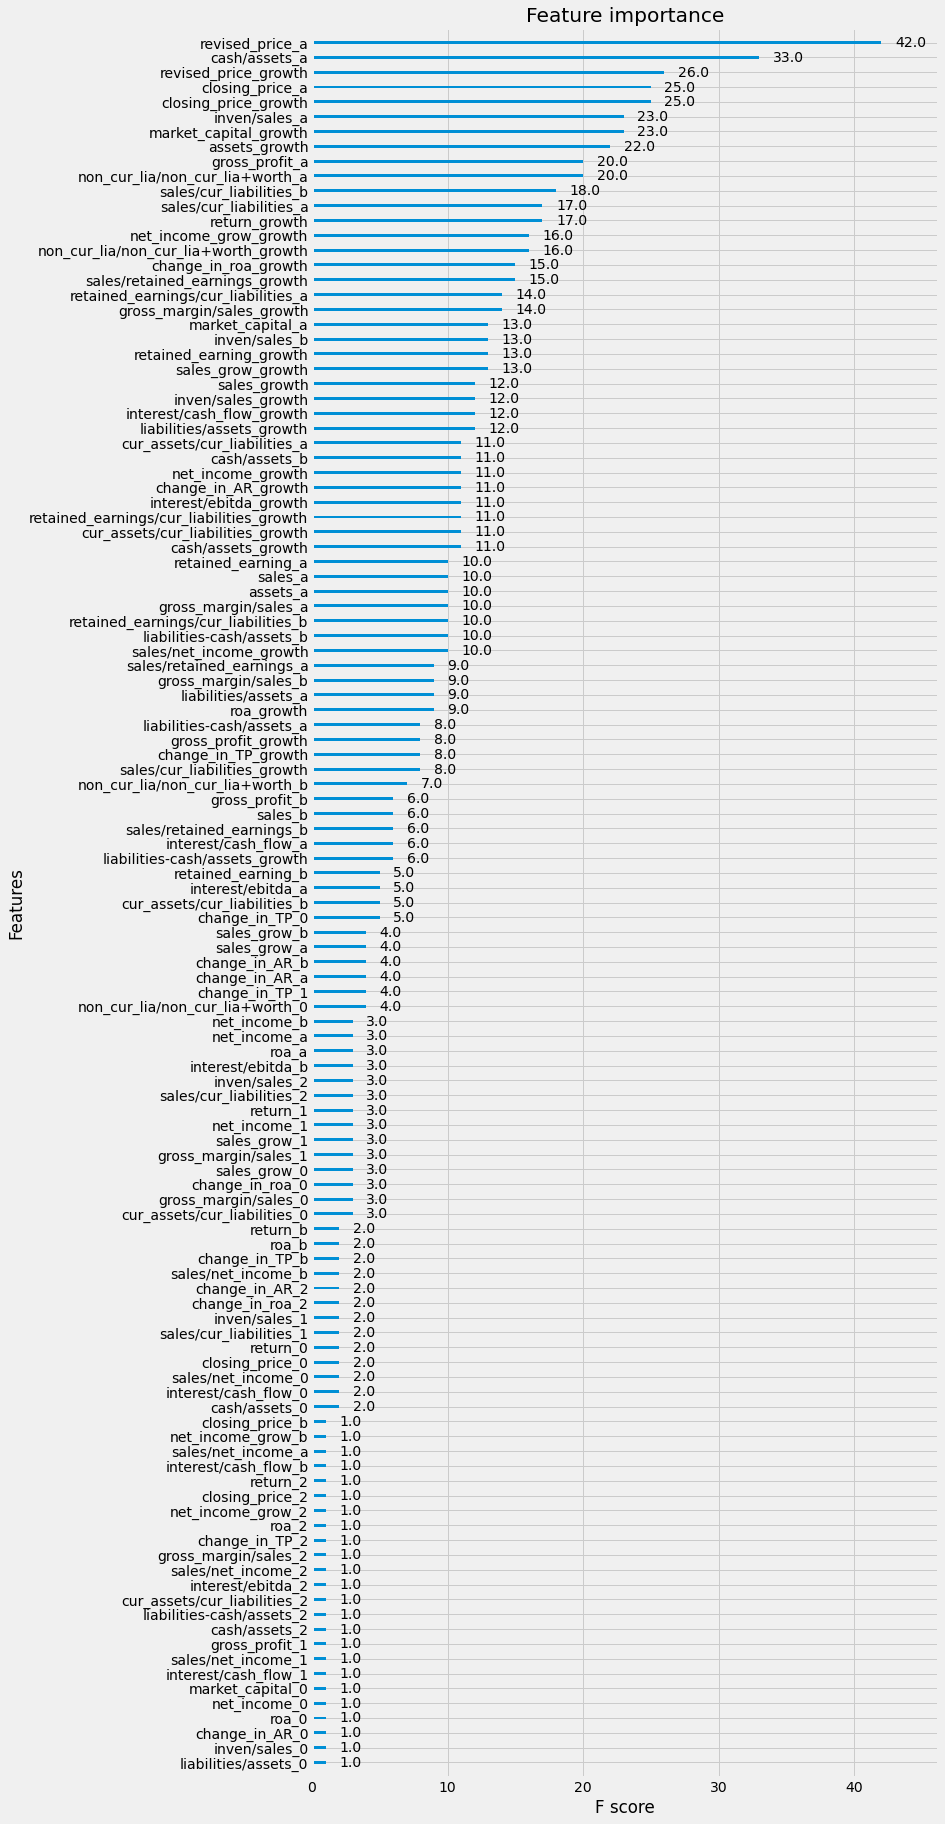

In [ ]:
union_X4 = union_train4.drop(['code_label', 'year', 'fnc_rsn_unlst_year'], axis=1)
union_y4 = union_train4['fnc_rsn_unlst_year']

union_result4 = xgb_smltn(union_X4, union_y4)

In [ ]:
print('year' in union_X4.columns)
print('code_label' in union_X4.columns)

False
False


In [ ]:
print("정확도:",accuracy_score(union_result4['y_pred'], union_result4['y_real']))

정확도: 0.9895757132406731


In [ ]:
result_count = pd.DataFrame(union_result4.groupby(['y_real','y_pred'])['y_pred'].count()).rename(columns={'y_pred':'count'}).reset_index()
print(union_result4.groupby(['y_real','y_pred'])['y_pred'].count(), '\n')
print('상장폐지를 상장유지로 예측:', result_count['count'][1], '/',result_count['count'][0]+result_count['count'][1])
print('상장유지를 상장폐지로 예측:',result_count['count'][2], '/',result_count['count'][2]+result_count['count'][3])
print(round(result_count['count'][1]/(result_count['count'][0]+result_count['count'][1]),4))
print(round(result_count['count'][2]/(result_count['count'][2]+result_count['count'][3]),4))

y_real  y_pred
0       0         10807
        1             9
1       0           105
        1            15
Name: y_pred, dtype: int64 

상장폐지를 상장유지로 예측: 9 / 10816
상장유지를 상장폐지로 예측: 105 / 120
0.0008
0.875


In [ ]:
def without_stock(df):
  X = df.loc[:,'year':'retained_earning']
  X['code_label'] = df['code_label']
  X['fnc_rsn_unlst_year'] = df['fnc_rsn_unlst_year']

  return X

panel_a_without_stock = without_stock(panel_a)

In [ ]:
def train_last_row_grwth_non_lnr(df, contained_year1, contained_year2, contained_year3):

  df_without_stock = without_stock(df)#.drop(['year'], axis=1)

  last_fnc_data = train_last_fnc(df).drop(['fnc_rsn_unlst_year'], axis=1).drop(['코드대분류','최초상장일자', '상장일자', 'unlist_date', 'unlist_reason', 'unlist_year','unlist_reason_ctg', 'fnc_rsn_unlst_year', 'unlist_mon', 'unlist_last_year'], axis=1)
  train_row_data = train_row_to_col(df.loc[:,'year':'fnc_rsn_unlst_year'], contained_year2).drop(['fnc_rsn_unlst_year'], axis=1)
  train_growth_data = train_growth_rate(df.loc[:,'cash/assets':'fnc_rsn_unlst_year'], contained_year2).drop(['fnc_rsn_unlst_year'], axis=1)
  train_non_linea_data = train_non_linear(df_without_stock.loc[:,'cash/assets':'fnc_rsn_unlst_year'], contained_year3)

  result = last_fnc_data.merge(train_row_data, how='outer',on='code_label')
  result = result.merge(train_growth_data, how='outer',on='code_label')
  result = result.merge(train_non_linea_data, how='outer',on='code_label')

  return result
  
union_train5 = train_last_row_grwth_non_lnr(panel_a, 2, 3, 2)

  0%|          | 0/30 [00:00<?, ?it/s]<ipython-input-27-70b133b319d3>:2: RuntimeWarning: divide by zero encountered in double_scalars
  rate = (p1 - p0)/p0 #증가율 계산 = (현재시점-이전시점)/(이전시점)
<ipython-input-27-70b133b319d3>:2: RuntimeWarning: invalid value encountered in double_scalars
  rate = (p1 - p0)/p0 #증가율 계산 = (현재시점-이전시점)/(이전시점)
  0%|          | 0/26 [00:00<?, ?it/s]<ipython-input-30-649cbbb9e786>:20: RuntimeWarning: divide by zero encountered in log
  Y = np.log(y)
<ipython-input-29-77dc735660f7>:2: RuntimeWarning: invalid value encountered in multiply
  b = (np.mean(x)*np.mean(Y) - np.mean(x*Y))/(np.mean(x)*np.mean(x)-np.mean(x*x))
<ipython-input-30-649cbbb9e786>:20: RuntimeWarning: invalid value encountered in log
  Y = np.log(y)
100%|██████████| 3047/3047 [00:18<00:00, 166.81it/s]


In [ ]:
union_train5

code  cor_name  Accounting_Closing  year  cash/assets  \
0     A005930      삼성전자                12.0  2021     0.091490   
1     A373220  LG에너지솔루션                12.0  2021     0.053984   
2     A000660    SK하이닉스                12.0  2021     0.052476   
3     A207940  삼성바이오로직스                12.0  2021     0.005949   
4     A006400     삼성SDI                12.0  2021     0.090027   
...       ...       ...                 ...   ...          ...   
3042  A900180        완리                12.0  2017     0.170397   
3043  A950010  평산차업 KDR                12.0  2014     0.296593   
3044  A950030    네프로아이티                 3.0  2010     0.073408   
3045  A950070      중국고섬                12.0  2012     0.008260   
3046  A950180       SNK                 7.0  2021     0.694562   

      liabilities/assets  liabilities-cash/assets  sales/cur_liabilities  \
0               0.285315                 0.193825               3.173104   
1               0.632119                 0.578135               1.884302   
2               0.354774                 0.302298               2.911284   
3               0.373765                 0.367816               1.416070   
4               0.411737                 0.321710               2.097604   
...                  ...                      ...                    ...   
3042            0.315057                 0.144660               1.837878   
3043            0.284505                -0.012087               0.525747   
3044            0.707520                 0.634112               0.880812   
3045            0.425390                 0.417130               0.599048   
3046            0.101859                -0.592702               2.830798   

      cur_assets/cur_liabilities  retained_earnings/cur_liabilities  ...  \
0                       2.475832                           3.325854  ...   
1                       1.006524                           0.035633  ...   
2                       1.819338                           3.777014  ...   
3                       2.549615                           2.119749  ...   
4                       1.152233                           1.318077  ...   
...                          ...                                ...  ...   
3042                    1.693219                           2.568629  ...   
3043                    2.115551                          -0.425187  ...   
3044                    0.828345                          -1.541515  ...   
3045                    0.343097                          -0.671742  ...   
3046                    9.826040                           1.322351  ...   

      net_income_b  net_income_grow_a  net_income_grow_b  gross_profit_a  \
0         0.412902              21.48           0.867054    9.231869e+10   
1              NaN                NaN                NaN    2.240480e+08   
2         0.703428             136.87          -0.293373    1.081063e+10   
3         0.490616              18.76           1.216632    4.160761e+08   
4         0.683968              56.81           0.546988    2.380553e+09   
...            ...                ...                ...             ...   
3042     -0.147541                NaN                NaN    6.380107e+07   
3043           NaN                NaN                NaN    1.270216e+07   
3044           NaN                NaN                NaN    8.680043e+06   
3045           NaN                NaN                NaN    1.392580e+06   
3046           NaN                NaN                NaN    7.277991e+07   

      gross_profit_b  operating_profit_a  operating_profit_b  \
0           0.203852               21.48            0.867054   
1           2.856559                 NaN                 NaN   
2           0.561390              136.87           -0.293373   
3           0.557303               18.76            1.216632   
4           0.256823               56.81            0.546988   
...              ...                 ...                 ...   
3042       -0.361355         

In [ ]:
union_X5 = union_train5.loc[:,'year':'retained_earning_b'].drop(['year', 'code_label'], axis=1)
union_y5 = union_train5['fnc_rsn_unlst_year']

union_result5 = xgb_smltn(union_X5, union_y5)

NameError: ignored

In [ ]:
union_result5

NameError: ignored

In [ ]:
print('code_label' in union_X5.columns)
print('year' in union_X5.columns)

False
False


In [ ]:
print("정확도:",accuracy_score(union_result5['y_pred'], union_result5['y_real']))

NameError: ignored

In [ ]:
result_count = pd.DataFrame(union_result5.groupby(['y_real','y_pred'])['y_pred'].count()).rename(columns={'y_pred':'count'}).reset_index()
print(union_result5.groupby(['y_real','y_pred'])['y_pred'].count(), '\n')
print('상장폐지를 상장유지로 예측:', result_count['count'][1], '/',result_count['count'][0]+result_count['count'][1])
print('상장유지를 상장폐지로 예측:',result_count['count'][2], '/',result_count['count'][2]+result_count['count'][3])
print(round(result_count['count'][1]/(result_count['count'][0]+result_count['count'][1]),4))
print(round(result_count['count'][2]/(result_count['count'][2]+result_count['count'][3]),4))

NameError: ignored

# #과적합 검사

In [ ]:
def overfitting_test(X, y):

  X_train_val,X_test,y_train_val,y_test= train_test_split(X, y, test_size=0.2, random_state=1, stratify=y, shuffle=True)
  X_train,X_val,y_train,y_val= train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=1, stratify=y_train_val, shuffle=True)

  # 객체 생성
  model = XGBClassifier(n_estimators=500, early_stopping_rounds=100, max_depth=3, random_state=0)
  xgb_model = model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

  # 예측하기
  y_pre = xgb_model.predict(X_train)
  y_pred_probs = xgb_model.predict_proba(X_train)[:,1]

  # 특성 중요도 시각화
  fig, ax = plt.subplots(figsize=(10,30))
  plot_importance(xgb_model, ax=ax)

  X_train['y_real'] = y_train
  X_train['y_pred'] = y_pre
  X_train['y_pred_probs'] = y_pred_probs

  print("정확도:",accuracy_score(y_pre, y_train))

  return X_train

[0]	validation_0-logloss:0.44774
[1]	validation_0-logloss:0.31284
[2]	validation_0-logloss:0.22837
[3]	validation_0-logloss:0.17235
[4]	validation_0-logloss:0.13425
[5]	validation_0-logloss:0.10753
[6]	validation_0-logloss:0.08895
[7]	validation_0-logloss:0.07555
[8]	validation_0-logloss:0.06632
[9]	validation_0-logloss:0.05959
[10]	validation_0-logloss:0.05482
[11]	validation_0-logloss:0.05123
[12]	validation_0-logloss:0.04893
[13]	validation_0-logloss:0.04706
[14]	validation_0-logloss:0.04579
[15]	validation_0-logloss:0.04504
[16]	validation_0-logloss:0.04444
[17]	validation_0-logloss:0.04400
[18]	validation_0-logloss:0.04356
[19]	validation_0-logloss:0.04339
[20]	validation_0-logloss:0.04334
[21]	validation_0-logloss:0.04326
[22]	validation_0-logloss:0.04293
[23]	validation_0-logloss:0.04288
[24]	validation_0-logloss:0.04287
[25]	validation_0-logloss:0.04280
[26]	validation_0-logloss:0.04288
[27]	validation_0-logloss:0.04272
[28]	validation_0-logloss:0.04263
[29]	validation_0-loglos

정확도: 0.9909153633854646


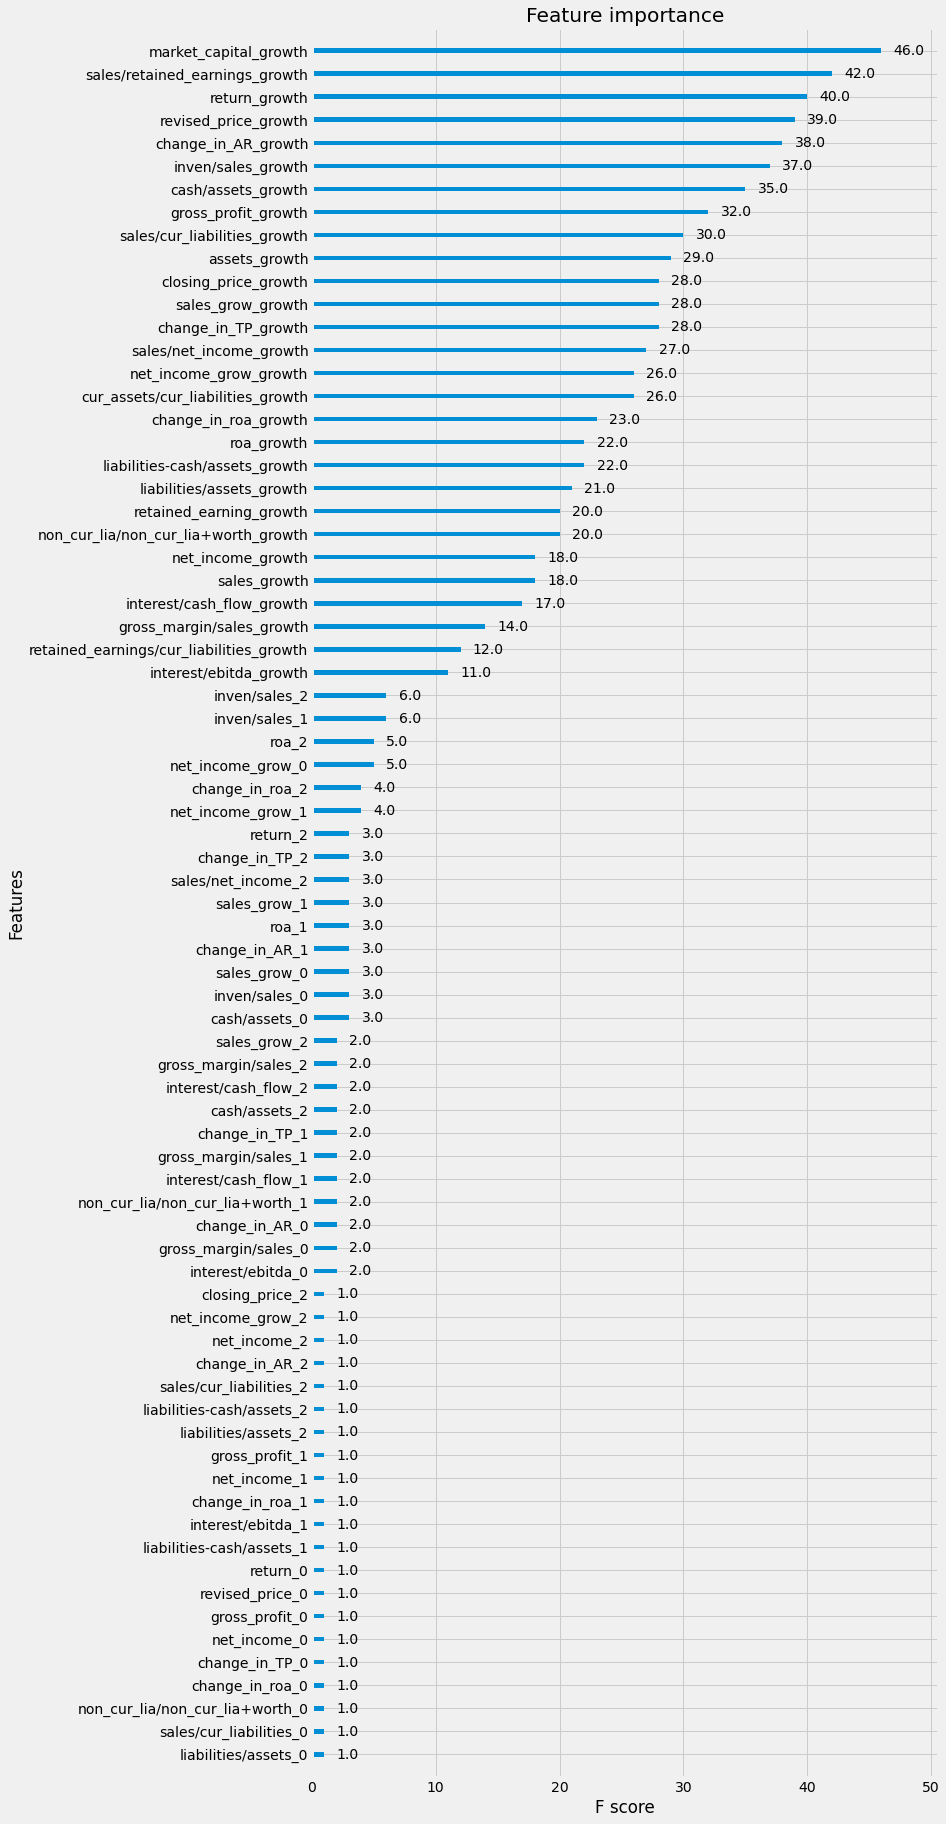

In [ ]:
X4_1 = union_train1.drop(['code_label', 'year', 'fnc_rsn_unlst_year'], axis=1)
y4_1 = union_train1['fnc_rsn_unlst_year']

union_result4_1 = overfitting_test(X4_1, y4_1)

In [ ]:
print("정확도:",accuracy_score(union_result4_1['y_pred'], union_result4_1['y_real']))

result_count = pd.DataFrame(union_result4_1.groupby(['y_real','y_pred'])['y_pred'].count()).rename(columns={'y_pred':'count'}).reset_index()
print(union_result4_1.groupby(['y_real','y_pred'])['y_pred'].count(), '\n')
print('상장유지를 상장폐지로 예측:', result_count['count'][1], '/',result_count['count'][0]+result_count['count'][1])
print('상장폐지를 상장유지로 예측:',result_count['count'][2], '/',result_count['count'][2]+result_count['count'][3])
print(round(result_count['count'][1]/(result_count['count'][0]+result_count['count'][1]),4))
print(round(result_count['count'][2]/(result_count['count'][2]+result_count['count'][3]),4))

정확도: 0.9909153633854646
y_real  y_pred
0       0         34404
        1            10
1       0           306
        1            64
Name: y_pred, dtype: int64 

상장유지를 상장폐지로 예측: 10 / 34414
상장폐지를 상장유지로 예측: 306 / 370
0.0003
0.827


# #4. 다운샘플링

In [ ]:
import random
print(round(len(panel_a[panel_a['fnc_rsn_unlst_year']==1]) / len(panel_a[panel_a['fnc_rsn_unlst_year']==0]) *100, 4), "%")

1.1272 %


In [ ]:
def down_sampling(df, percent):
  down_sample_indices = [0,2,3]
  rest_df = df.loc[[idx for idx in df.index if idx not in down_sample_indices],:]

  return rest_df

result4_1 = down_sampling(union_train1, 10)
result4_1

cash/assets_0  liabilities/assets_0  liabilities-cash/assets_0  \
1                NaN                   NaN                        NaN   
4           0.026253              0.819760                   0.793507   
5           0.033530              0.793795                   0.760265   
6           0.022999              0.692778                   0.669779   
7           0.054644              0.693142                   0.638497   
...              ...                   ...                        ...   
54347            NaN                   NaN                        NaN   
54348            NaN                   NaN                        NaN   
54349       0.026243              0.805812                   0.779569   
54350       0.011561              0.825602                   0.814041   
54351       0.026253              0.819760                   0.793507   

       sales/cur_liabilities_0  cur_assets/cur_liabilities_0  \
1                          NaN                           NaN   
4                     2.032037                      0.708325   
5                     2.495139                      0.815311   
6                     3.189266                      1.128719   
7                     2.801825                      1.333899   
...                        ...                           ...   
54347                      NaN                           NaN   
54348                      NaN                           NaN   
54349                 2.738511                      0.948362   
54350                 1.887630                      0.740129   
54351                 2.032037                      0.708325   

       retained_earnings/cur_liabilities_0  non_cur_lia/non_cur_lia+worth_0  \
1                                      NaN                              NaN   
4                                 0.146367                         0.656881   
5                                 0.162677                         0.649281   
6                                 0.412265                         0.501214   
7                                 0.514395                         0.494786   
...                                    ...                              ...   
54347                                  NaN                              NaN   
54348                                  NaN                              NaN   
54349                             0.223232                         0.672144   
54350                             0.145565                         0.651638   
54351                             0.146367                         0.656881   

       interest/cash_flow_0  interest/ebitda_0  inven/sales_0  \
1                       NaN                NaN            NaN   
4                  0.001486           0.000561       0.142004   
5                  0.000000           0.000000       0.124302   
6                  0.000000           0.000000       0.098240   
7                  0.001220           0.000839       0.161051   
...                     ...                ...            ...   
54347                   NaN                NaN            NaN   
54348                   NaN                NaN            NaN   
54349              0.000012           0.000008       0.160206   
54350              0.000000           0.000000       0.174542   
54351              0.001486           0.000561       0.142004   

       sales/net_income_0  gross_margin/sales_0  sales/retained_earnings_0  \
1                     NaN                   NaN                        NaN   
4               84.247871              0.272204                  13.883191   
5              113.547603              0.308030                  15.337989   
6               11.736092              0.375319                   7.735951   
7                8.835909              0.389539                   5.446841   
...                   ...                   ...                        ...   
54347                 NaN                   NaN                        NaN   
54348  

In [ ]:
def down_sampling(df, percent):
  cnt_0 = len(df[df['fnc_rsn_unlst_year']==0])
  cnt_1 = len(df[df['fnc_rsn_unlst_year']==1])

  random_indices = np.random.choice(df[df['fnc_rsn_unlst_year']==0].index, cnt_1 * percent, replace=False)

  down_sample_indices = np.concatenate([df[df['fnc_rsn_unlst_year']==1].index, random_indices])
  down_df = df.loc[down_sample_indices].reset_index(drop=True) #'code_label':'fnc_rsn_unlst_year'
  down_df.replace([np.inf, -np.inf], np.nan, inplace=True)

  print(down_df.groupby('fnc_rsn_unlst_year')['fnc_rsn_unlst_year'].count())

  X_train = down_df.drop(['fnc_rsn_unlst_year','code_label'], axis=1)
  y_train = down_df['fnc_rsn_unlst_year']
  
  rest_df = df.loc[[idx for idx in df.index if idx not in down_sample_indices],:].reset_index(drop=True)
  X_val,X_test,y_val,y_test= train_test_split(rest_df.drop(['fnc_rsn_unlst_year','code_label'], axis=1), rest_df['fnc_rsn_unlst_year'], test_size=0.2, random_state=1, stratify=rest_df['fnc_rsn_unlst_year'], shuffle=True)

  # 객체 생성
  model = XGBClassifier(n_estimators=500, early_stopping_rounds=100, max_depth=3, random_state=0)
  xgb_model = model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

  # 예측하기
  y_pre = xgb_model.predict(X_test)
  y_pred_probs = xgb_model.predict_proba(X_test)[:,1]

  # 특성 중요도 시각화
  fig, ax = plt.subplots(figsize=(10,30))
  plot_importance(xgb_model, ax=ax)

  X_test['y_real'] = y_test
  X_test['y_pred'] = y_pre
  X_test['y_pred_probs'] = y_pred_probs

  print("정확도:",accuracy_score(y_pre, y_test))

  return X_test

result4_1 = down_sampling(union_train1, 20)

In [ ]:
print("정확도:",accuracy_score(result4_1['y_pred'], result4_1['y_real']))
result_count = pd.DataFrame(result4_1.groupby(['y_real','y_pred'])['y_pred'].count()).rename(columns={'y_pred':'count'}).reset_index()
print(result4_1.groupby(['y_real','y_pred'])['y_pred'].count(), '\n')
print('상장유지를 상장폐지로 예측:', result_count['count'][1], '/',result_count['count'][0]+result_count['count'][1])
print('상장폐지를 상장유지로 예측:',result_count['count'][2], '/',result_count['count'][2]+result_count['count'][3])
print(round(result_count['count'][1]/(result_count['count'][0]+result_count['count'][1]),4))
print(round(result_count['count'][2]/(result_count['count'][2]+result_count['count'][3]),4))

정확도: 0.9914681834340562
y_real  y_pred
0       0         8367
        1           72
Name: y_pred, dtype: int64 

상장유지를 상장폐지로 예측: 72 / 8439


KeyError: ignored

In [ ]:
# result_count @@ test에 1이 없다

y_real  y_pred  count
0       0       0   8367
1       0       1     72

# #5. 업 샘플링

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

# scaler = MinMaxScaler(feature_range=(0, 1))
# scaler.fit_transform(X_train)
# X_train = scaler.fit_transform(X_train)

In [ ]:
def up_sampling(df, percent):
  fnc_1 = df[df['fnc_rsn_unlst_year']==1]
  # fnc_1 = fnc_1.dropna(subset = fnc_1.loc[:,'cash/assets':'net_income_grow'].columns,axis = 0, how='all').reset_index(drop=True)
  
  X_fnc_1 = fnc_1.drop(['fnc_rsn_unlst_year','code_label'], axis=1)
  y_fnc_1 = fnc_1['fnc_rsn_unlst_year']

  adasyn = ADASYN(random_state=22)
  X_upsmpl, y_upsmpl = smote.fit_resample(X_fnc_1, y_fnc_1)

  # random_indices = np.random.choice(df[df['fnc_rsn_unlst_year']==0].index, cnt_1 * percent, replace=False)

  # down_sample_indices = np.concatenate([df[df['fnc_rsn_unlst_year']==1].index, random_indices])
  # down_df = df.loc[down_sample_indices].reset_index(drop=True) #'code_label':'fnc_rsn_unlst_year'
  # down_df.replace([np.inf, -np.inf], np.nan, inplace=True)

  # print(down_df.groupby('fnc_rsn_unlst_year')['fnc_rsn_unlst_year'].count())

  # X_train = down_df.drop(['fnc_rsn_unlst_year','code_label'], axis=1)
  # y_train = down_df['fnc_rsn_unlst_year']
  
  # rest_df = df.loc[[idx for idx in df.index if idx not in down_sample_indices],:].reset_index(drop=True)
  # X_val,X_test,y_val,y_test= train_test_split(rest_df.drop(['fnc_rsn_unlst_year','code_label'], axis=1), rest_df['fnc_rsn_unlst_year'], test_size=0.2, random_state=1, stratify=rest_df['fnc_rsn_unlst_year'], shuffle=True)

  # # 객체 생성
  # model = XGBClassifier(n_estimators=500, early_stopping_rounds=100, max_depth=3, random_state=0)
  # xgb_model = model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

  # # 예측하기
  # y_pre = xgb_model.predict(X_test)
  # y_pred_probs = xgb_model.predict_proba(X_test)[:,1]

  # # 특성 중요도 시각화
  # fig, ax = plt.subplots(figsize=(10,30))
  # plot_importance(xgb_model, ax=ax)

  # X_test['y_real'] = y_test
  # X_test['y_pred'] = y_pre
  # X_test['y_pred_probs'] = y_pred_probs

  # print("정확도:",accuracy_score(y_pre, y_test))

  return X_upsmpl, y_upsmpl

X_upsmpl, y_upsmpl = up_sampling(union_train1, 20)

ValueError: ignored

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_churn_sm, Y_churn_sm = smote.fit_resample(X_churn, Y_churn)

NameError: ignored

In [ ]:
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

# 모델설정
sm = SMOTE(ratio='auto', kind='regular')

# train데이터를 넣어 복제함
X_resampled, y_resampled = sm.fit_sample(X_train,list(y_train))

print('After OverSampling, the shape of train_X: {}'.format(X_resampled.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(X_resampled.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_resampled==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_resampled==0)))

In [ ]:
X_resampled.shape, y_resampled.shape

# #6. shift

# #5. Bayesian Optimization

In [ ]:
!pip install bayesian-optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
union_X4 = union_train4.loc[:,'year':'return_b'].drop(['year', 'code_label'], axis=1)
union_y4 = union_train4['fnc_rsn_unlst_year']

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error
import xgboost as xgb

# 탐색 대상 함수 (XGBClassifier)
def XGB_cv(max_depth,learning_rate, n_estimators, gamma, min_child_weight, subsample, colsample_bytree, silent=True, nthread=-1):

  X_train,X_test,y_train,y_test= train_test_split(union_X4, union_y4,test_size=0.2,random_state=1)

  # 모델 정의
  model = xgb.XGBClassifier(max_depth=int(max_depth),
                           learning_rate=learning_rate,
                           n_estimators=int(n_estimators),
                           gamma=gamma,
                           min_child_weight=min_child_weight,
                           subsample=subsample,
                           colsample_bytree=colsample_bytree, 
                           nthread=nthread,
                            early_stopping_rounds=1
                           )
  # 모델 훈련
  model.fit(X_train, y_train)

  # 예측값 출력
  y_pred= model.predict(X_test)

  # 정확도
  score = accuracy_score(y_test, y_pred)
  
  return score 

In [ ]:
#  bayesian-optimization 라이브러리의 BayesianOptimization 클래스 import
from bayes_opt import BayesianOptimization
import numpy as np

# 실험해보고자하는 hyperparameter 집합
pbounds = {'max_depth': (3, 4), 
           'learning_rate': (0.01, 1),
           'n_estimators': (500, 600),
           'gamma': (13, 14),
           'min_child_weight': (0, 2),
           'subsample': (0.1, 0.8),
           'colsample_bytree' :(0.9, 1)
           }

## Bayesian optimization 객체 생성
# f : 탐색 대상 함수, pbounds : hyperparameter 집합
# verbose = 2 항상 출력, verbose = 1 최댓값일 때 출력, verbose = 0 출력 안함
# random_state : Bayesian Optimization 상의 랜덤성이 존재하는 부분을 통제 
bo = BayesianOptimization(f=XGB_cv, pbounds=pbounds, verbose=2, random_state=1 )    

## 메소드를 이용해 최대화 과정 수행
# init_points :  초기 Random Search 갯수
# n_iter : 반복 횟수 (몇개의 입력값-함숫값 점들을 확인할지! 많을 수록 정확한 값을 얻을 수 있다.)
# acq : Acquisition Function들 중 Expected Improvement(EI) 를 사용
# xi : exploration 강도 (기본값은 0.0)
bo.maximize(init_points=2, n_iter=30, acq='ei', xi=0.01)

# 'iter'는 반복 회차, 'target'은 목적 함수의 값, 나머지는 입력값을 나타냅니다. 
# 현재 회차 이전까지 조사된 함숫값들과 비교하여, 현재 회차에 최댓값이 얻어진 경우, 
# bayesian-optimization 라이브러리는 이를 자동으로 다른 색 글자로 표시하는 것을 확인할 수 있습니다

# 찾은 파라미터 값 확인
print(bo.max)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------


<ipython-input-98-ce18fb9a4a98>:26: DeprecationWarning: 
Passing acquisition function parameters or gaussian process parameters to maximize
is no longer supported, and will cause an error in future releases. Instead,
please use the "set_gp_params" method to set the gp params, and pass an instance
 of bayes_opt.util.UtilityFunction using the acquisition_function argument

  bo.maximize(init_points=2, n_iter=30, acq='ei', xi=0.01)


| 1         | 0.8738    | 0.9417    | 13.72     | 0.01011   | 3.302     | 0.2935    | 509.2     | 0.2304    |
| 2         | 0.8803    | 0.9346    | 13.4      | 0.5434    | 3.419     | 1.37      | 520.4     | 0.7147    |
| 3         | 0.8852    | 0.975     | 13.11     | 0.6284    | 3.387     | 1.34      | 520.4     | 0.4695    |
| 4         | 0.8656    | 0.9109    | 13.37     | 0.5402    | 3.53      | 1.273     | 520.2     | 0.3131    |
| 5         | 0.8852    | 0.9965    | 13.07     | 0.06171   | 3.612     | 1.158     | 586.1     | 0.3818    |
| 6         | 0.8738    | 0.9323    | 13.71     | 0.4851    | 3.027     | 1.365     | 578.0     | 0.7818    |
| 7         | 0.841     | 0.9441    | 13.51     | 0.588     | 3.839     | 0.005394  | 581.8     | 0.1778    |
| 8         | 0.882     | 0.9717    | 13.65     | 0.1135    | 3.087     | 1.31      | 583.1     | 0.2413    |
| 9         | 0.8705    | 0.9925    | 13.84     | 0.01751   | 3.894     | 0.01073   | 550.9     | 0.4111    |
| 10      

In [ ]:
bo.res

[{'target': 0.8737704918032787,
  'params': {'colsample_bytree': 0.9417022004702574,
   'gamma': 13.720324493442158,
   'learning_rate': 0.010113231069171438,
   'max_depth': 3.3023325726318395,
   'min_child_weight': 0.2935117816342261,
   'n_estimators': 509.2338594768798,
   'subsample': 0.23038214796436965}},
 {'target': 0.8803278688524591,
  'params': {'colsample_bytree': 0.9345560727043047,
   'gamma': 13.39676747423067,
   'learning_rate': 0.5434285666633234,
   'max_depth': 3.4191945144032947,
   'min_child_weight': 1.370439000793519,
   'n_estimators': 520.4452249731518,
   'subsample': 0.7146822054736618}},
 {'target': 0.8852459016393442,
  'params': {'colsample_bytree': 0.9750124248068985,
   'gamma': 13.109735021285656,
   'learning_rate': 0.6283773710840848,
   'max_depth': 3.3873605221444807,
   'min_child_weight': 1.340180737495614,
   'n_estimators': 520.3560377661902,
   'subsample': 0.46954315827151183}},
 {'target': 0.8655737704918033,
  'params': {'colsample_bytree'

# #6. predict_prob

- https://xgboost.readthedocs.io/en/stable/python/python_api.html

In [ ]:
def xgb_smltn(X, y):

  X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.2,random_state=1)

  # 객체 생성
  model = XGBClassifier(n_estimators=500, early_stopping_rounds=1, max_depth=3, random_state=0)
  xgb_model = model.fit(X_train, y_train, early_stopping_rounds=100,eval_set=[(X_test, y_test)])

  # 예측하기
  y_pre = xgb_model.predict(X_test)
  y_pred_probs = xgb_model.predict_proba(X_test)[:,1]

  # # 특성 중요도 시각화
  # fig, ax = plt.subplots(figsize=(10,12))
  # plot_importance(xgb_model, ax=ax)

  X_test['y_real'] = y_test
  X_test['y_pred'] = y_pre

  print("정확도:",accuracy_score(y_pre, y_test))

  return X_test